IDEAT: Vix takas? Joku momentum indikaattori? Sentimentti?




##Model settings

In [ ]:
use_regime_split = False

#Default models
RF = True # perus random forest
RF2 = False
GB = False # perus gradient boost
Hybrid = False

#Looping models
RF_feature_seek = False # random forest all combinations
seek_all = False
gb_loop = False

#DATA
FF5 = True
FF5_long = False
MSCI = False

RSI = True

local = False #ajetaanko colab vai oma kone




In [ ]:
# Identify active model flags
active_modes = [name for name, flag in zip(
    ['RF', 'GB', 'RF_feature_seek', 'Hybrid', 'seek_all', 'gb_loop'],
    [RF, GB, RF_feature_seek, Hybrid, seek_all, gb_loop]
) if flag]

if active_modes:
    print("✅ Active model modes:", ", ".join(active_modes))
else:
    print("⚠️ No active model mode selected.")

# Check dataset toggles: exactly one must be True
datasets = {
    'FF5': FF5,
    'FF5_long': FF5_long,
    'MSCI': MSCI
}
active_datasets = [name for name, flag in datasets.items() if flag]

if len(active_datasets) != 1:
    raise ValueError("Error: Exactly one of [FF5, FF5_long, MSCI] must be True.")
else:
    print(f"📊 Using dataset: {active_datasets[0]}")


✅ Active model modes: RF
📊 Using dataset: FF5


In [ ]:
# # Import Required Libraries
#
# Import all necessary libraries for data manipulation, visualization,
# machine learning, and regression analysis.

# %%
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from tabulate import tabulate

from IPython.display import display, HTML


In [ ]:
if not local:

  %cd /content
  !rm -rf Gradu
  !git clone https://github.com/Elkkujou/Gradu.git
  %cd /content/Gradu
  !ls
  xls_file = pd.ExcelFile("/content/Gradu/THE_2ND_latest.xlsx")

else:



    repo_url = "https://github.com/Elkkujou/Gradu.git"
    repo_name = "Gradu"  # Name of the cloned folder

    # Check if the directory already exists
    if os.path.exists(repo_name):
        print(f"Folder '{repo_name}' already exists. Pulling latest changes...")
        # Change to the existing repo folder and pull the latest updates
        subprocess.run(["git", "-C", repo_name, "pull"], check=True)
    else:
        print(f"Cloning repository into '{repo_name}'...")
        subprocess.run(["git", "clone", repo_url], check=True)

    # List contents of the cloned repository
    subprocess.run(["ls", repo_name], check=True)
    xls_file = pd.ExcelFile("Gradu/THE_2ND_latest.xlsx")



/content
Cloning into 'Gradu'...
remote: Enumerating objects: 938, done.
remote: Counting objects: 100% (239/239), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 938 (delta 198), reused 128 (delta 128), pack-reused 699 (from 1)
Receiving objects: 100% (938/938), 212.05 MiB | 20.75 MiB/s, done.
Resolving deltas: 100% (465/465), done.
/content/Gradu
 chatti_RF.ipynb		      regime_prediction_msci.ipynb
 data+regimes.xlsx		      regime_pred.txt
 Fama_french_XGBOOST.ipynb	      RF_Gradu.ipynb
'Financial turbulence.ipynb'	     'RF REGIIMI HYVÄ TRAINING.ipynb'
 FT_source.xlsx			     'RF_REGIIMI_HYVÄ_TRAINING (MSCI).ipynb'
 Gradient_boost_malli.ipynb	     'RF_regime (3).ipynb'
 MSCI_XGBOOST.ipynb		      THE_2ND_latest.xlsx
 Regiimi_prediction.ipynb	      THE_2ND.xlsx
 regime_prediction_famafrench.ipynb   THE_ONE.xlsx


In [ ]:
if FF5:
  SHEET_NAME = "ajodata_FF5"
  FEATURES = ['CPI%','T10Y3', 'CFNAI', 'GARCH_1M']
  FACTORS = [
    'SMB',
    'HML',
    'CMA',
    'RMW',
    #'RF'
]
  BENCHMARK = ['Mkt']
  show_benchmark = False

In [ ]:
if FF5_long:
  SHEET_NAME = "ajodata_FF5_long"
  FEATURES = ['CPI%','T10Y3', 'CFNAI', 'GARCH_1M']
  FACTORS = [
    'SMB',
    'HML',
    'CMA',
    'RMW',
    #'RF'
]
  BENCHMARK = ['Mkt']
  show_benchmark = True

In [ ]:
if MSCI:
  SHEET_NAME = "ajodata_MSCI"
  FEATURES = ['CPI%','T10Y3', 'CFNAI', 'GARCH_1M']
  FACTORS = [
    'Size',
    'value',
    'Quality',
    'min_vola']
  BENCHMARK = ['Us_standard']
  show_benchmark = True

##Prepare data

In [ ]:
df = xls_file.parse(SHEET_NAME)
df.columns = df.columns.get_level_values(0)

# Print headers dynamically
print(f"Headers in the '{SHEET_NAME}' sheet:")
print(df.columns)

REGIMES_COLUMN = 'Predicted_reg'

# Convert the leftmost column (assumed to be the date column) to datetime
date_column = df.columns[0]
df[date_column] = pd.to_datetime(df[date_column])

# Retrieve first and last observation dates and count observations
first_date = df[date_column].iloc[0]
last_date = df[date_column].iloc[-1]
n_observations = len(df)

# Create a DataFrame with the information
info_df = pd.DataFrame({
    "Description": ["First observation date", "Last observation date", "Total number of observations"],
    "Value": [first_date, last_date, n_observations]
})

# Display the results as a neat HTML table
display(HTML(info_df.to_html(index=False, classes="table table-striped", border=0)))



Headers in the 'ajodata_FF5' sheet:
Index(['Date', 'SMB', 'HML', 'RMW', 'CMA', 'Mkt', 'RF', 'Mkt-RF', 'GARCH_1M',
       'CPI%', 'T10YFF', 'Amihud', 'LEI%', 'Cape', 'Cape %', 'GDP', 'TED',
       'T10Y3', 'LEI', 'CFNAI', 'HV', 'VIX', 'EWMA', 'AvgShock', 'AR_Shock',
       'RealizedVol', 'RelVol_12m', 'VolBucket', 'GARCH_1M_REL', 'EWMA_1M_REL',
       'EWMA_0.94'],
      dtype='object')


Description,Value
First observation date,1963-07-30 00:00:00
Last observation date,2024-11-30 00:00:00
Total number of observations,737


In [ ]:
if RSI:

  # --- Add lagged 12‑month moving average for each factor return ---
  for f in FACTORS:
      # shift by 1 so that MA at time t uses returns t-12…t-1
      df[f + '_MA12'] = (
          df[f]
          .shift(1)                          # drop “today”
          .rolling(window=12, min_periods=12)
          .mean()
      )

  # update your FEATURES list
  FEATURES += [f + '_MA12' for f in FACTORS]

  print("✨ Added lagged 12‑month MA columns:", [f + '_MA12' for f in FACTORS])
  print("🧩 New FEATURES list:", FEATURES)

✨ Added lagged 12‑month MA columns: ['SMB_MA12', 'HML_MA12', 'CMA_MA12', 'RMW_MA12']
🧩 New FEATURES list: ['CPI%', 'T10Y3', 'CFNAI', 'GARCH_1M', 'SMB_MA12', 'HML_MA12', 'CMA_MA12', 'RMW_MA12']


In [ ]:

# --- Define Helper Functions ---
def annualized_return(returns):
    """Compute the compounded annualized return (assuming monthly returns)."""
    return np.prod(1 + returns)**(12 / len(returns)) - 1

def compute_metrics(returns):
    """
    Compute key metrics for a returns series:
      - Annualized Return
      - Annualized Volatility (assuming monthly returns)
      - Total Cumulative Return
    """
    cumulative_returns = (1 + returns).cumprod()
    total_cum_return = cumulative_returns.iloc[-1] - 1
    ann_ret = annualized_return(returns)
    ann_vol = np.std(returns) * np.sqrt(12)
    return ann_ret, ann_vol, total_cum_return

# --- Compute Metrics for Benchmark and Each Factor ---
metrics = []

# Compute metrics for the benchmark.
benchmark_returns = df[BENCHMARK[0]]
bench_ann_ret, bench_ann_vol, bench_cum_return = compute_metrics(benchmark_returns)
metrics.append({
    "Strategy": "Benchmark",
    "Annualized Return": f"{bench_ann_ret*100:.2f}%",
    "Annualized Volatility": f"{bench_ann_vol*100:.2f}%",
    "Total Cumulative Return": f"{bench_cum_return*100:.2f}%"
})

# Compute metrics for each factor in FACTORS.
for factor in FACTORS:
    factor_returns = df[factor]
    factor_ann_ret, factor_ann_vol, factor_cum_return = compute_metrics(factor_returns)
    metrics.append({
        "Strategy": factor,
        "Annualized Return": f"{factor_ann_ret*100:.2f}%",
        "Annualized Volatility": f"{factor_ann_vol*100:.2f}%",
        "Total Cumulative Return": f"{factor_cum_return*100:.2f}%"
    })

# Create a DataFrame from the metrics.
metrics_df = pd.DataFrame(metrics)

# --- Display the Results as an HTML Table ---
display(HTML(metrics_df.to_html(index=False)))





Strategy,Annualized Return,Annualized Volatility,Total Cumulative Return
Benchmark,10.71%,15.46%,51691.71%
SMB,1.89%,10.55%,216.75%
HML,2.88%,10.37%,473.19%
CMA,2.88%,7.18%,472.94%
RMW,3.14%,7.67%,568.93%


In [ ]:
# Toggle for dropping rows with missing values in the FEATURES columns.
drop_empty = True

# 1) Print the initial number of rows.
initial_rows = len(df)
print(f"Total number of rows before cleaning: {initial_rows}")

# 2) Show missing‐value counts in FEATURES.
missing_counts = df[FEATURES].isna().sum()
print("\nMissing values in FEATURES before cleaning:")
print(missing_counts)

# 3) Drop any rows with NA in FEATURES, if requested.
if drop_empty:
    before = len(df)
    df.dropna(subset=FEATURES, inplace=True)
    df.reset_index(drop=True, inplace=True)
    dropped = before - len(df)
    print(f"\nDropped {dropped} rows due to missing FEATURES.")
else:
    print("\nKeeping all rows, including those with missing FEATURES.")

# 4) Re‐check that FEATURES are now complete:
print("\nMissing values in FEATURES after cleaning:")
print(df[FEATURES].isna().sum())

# 5) Compute your target column in‐place.
df['Winning Factor'] = df[FACTORS].idxmax(axis=1).astype('category')

# 6) (Optionally) create a numeric code column
df['Winning Factor Code'] = df['Winning Factor'].cat.codes

# 7) Quick summary:
print(f"\nFinal dataset now has {len(df)} rows.")
print("Target value counts:")
print(df['Winning Factor'].value_counts())

Total number of rows before cleaning: 737

Missing values in FEATURES before cleaning:
CPI%         0
T10Y3        0
CFNAI       45
GARCH_1M     0
SMB_MA12    12
HML_MA12    12
CMA_MA12    12
RMW_MA12    12
dtype: int64

Dropped 45 rows due to missing FEATURES.

Missing values in FEATURES after cleaning:
CPI%        0
T10Y3       0
CFNAI       0
GARCH_1M    0
SMB_MA12    0
HML_MA12    0
CMA_MA12    0
RMW_MA12    0
dtype: int64

Final dataset now has 692 rows.
Target value counts:
Winning Factor
SMB    210
RMW    209
HML    164
CMA    109
Name: count, dtype: int64


In [ ]:
if use_regime_split:

    # --- Regime Mapping & Conversion to Numeric Codes (Dynamic) ---

    # Dynamically extract the unique values in the REGIMES_COLUMN.
    unique_regimes = df[REGIMES_COLUMN].unique()

    # Convert the Regimes column to a categorical type with the unique values, ordered alphabetically.
    df[REGIMES_COLUMN] = pd.Categorical(df[REGIMES_COLUMN], categories=sorted(unique_regimes), ordered=True)

    # Create a dictionary mapping numeric codes to the regime names based on the unique values.
    regime_mapping = {i: cat for i, cat in enumerate(df[REGIMES_COLUMN].cat.categories)}

    # Now encode the Regimes column as numeric codes.
    df[REGIMES_COLUMN] = df[REGIMES_COLUMN].cat.codes

    # Create a mapping from numeric codes to original regime names.
    regime_short_mapping = {code: name for code, name in regime_mapping.items()}

    # Calculate the number of observations for each regime using value_counts (without reindexing).
    obs_counts = df[REGIMES_COLUMN].value_counts(sort=False)

    # Create a DataFrame preview of the regime mapping, including observation counts.
    mapping_table_data = []
    for code in regime_mapping.keys():
        mapping_table_data.append({
            "Numeric Code": code,
            "Original Name": regime_mapping.get(code, "N/A"),
            "Observations": obs_counts.get(code, 0)
        })

    # Append a row with the total observations.
    total_obs = obs_counts.sum()
    mapping_table_data.append({
        "Numeric Code": "",
        "Original Name": "Total",
        "Observations": total_obs
    })

    # Create the DataFrame for regime mapping preview and print.
    regime_mapping_df = pd.DataFrame(mapping_table_data)

    from tabulate import tabulate
    print("Preview of Dynamic Regime Mapping:")
    print(tabulate(regime_mapping_df, headers="keys", tablefmt="psql", showindex=False))


# Models

##Feature seek

In [ ]:
if RF_feature_seek:
    import itertools
    import os
    import time
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier

    # --------------------------
    # Parameters for Feature & Training Window Search
    # --------------------------
    min_features = 2                  # minimum number of features in a subset
    max_features = len(FEATURES)      # maximum number of features (or set to a smaller number if desired)

    # Define fixed rolling window sizes (in years) to test (assuming monthly data)
    training_window_years = [5, 10, 15, 20]

    # Also run an expanding window experiment
    run_expanding_window = True

    # Independent variable: minimum number of observations required for making a prediction.
    # This is now decoupled from the training window calculation.
    min_obs_for_prediction = 60  # adjust this value as desired

    output_filename = "feature_subset_results.csv"
    if os.path.exists(output_filename):
        os.remove(output_filename)

    # Ensure the data is sorted by date.
    df_sorted = df.sort_values('Date').reset_index(drop=True)

    # --------------------------
    # Outer Loop: Fixed Rolling Window Modes
    # --------------------------
    for years in training_window_years:
        # Convert years to number of observations (assume 12 obs per year)
        rolling_window_size = years * 12
        # Ensure predictions start only after both the rolling window and the independent minimum are met.
        start_index = max(min_obs_for_prediction, rolling_window_size)
        print(f"\n--- Testing fixed rolling window of {years} years "
              f"({rolling_window_size} observations, starting predictions at index {start_index}) ---")
        outer_start_time = time.time()

        # Inner loop over feature subset sizes
        for r in range(min_features, max_features + 1):
            # Loop over all combinations of size r
            for comb in itertools.combinations(FEATURES, r):
                current_features = list(comb)
                inner_start_time = time.time()
                print(f"\nTesting feature combination: {current_features}")
                results = []

                # Loop over test rows, starting when we have enough training data
                for i in range(start_index, len(df_sorted)):
                    test_row = df_sorted.iloc[i]
                    Predicted_month = test_row['Date']

                    # Build fixed rolling training window (most recent rolling_window_size observations)
                    train_window = df_sorted.iloc[i - rolling_window_size : i].copy()

                    # Ensure the last training observation is strictly before test row date
                    last_train_date = train_window['Date'].iloc[-1]
                    if (last_train_date.year == Predicted_month.year) and \
                       (last_train_date.month >= Predicted_month.month):
                        continue

                    # (Optional) Regime check if use_regime_split is True:
                    if use_regime_split:
                        regime_counts = train_window[REGIMES_COLUMN].value_counts()
                        insufficient_regimes = regime_counts[regime_counts < min_obs_regime].index.tolist()
                        if insufficient_regimes:
                            continue
                        current_regime = test_row[REGIMES_COLUMN]
                        train_window = train_window[train_window[REGIMES_COLUMN] == current_regime]
                        if len(train_window) < min_obs_regime:
                            continue

                    # Prepare training data for the current feature subset.
                    X_train = train_window[list(current_features)].dropna()
                    y_train = train_window['Winning Factor'].loc[X_train.index]
                    if len(X_train) < 1:
                        continue

                    # Train the RandomForest model.
                    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                    rf_model.fit(X_train, y_train)

                    # Use the last row of the training window as test data.
                    X_test = train_window[list(current_features)].iloc[[-1]].dropna()
                    if X_test.empty:
                        continue

                    predicted_probabilities = rf_model.predict_proba(X_test)[0]
                    predicted_winner = rf_model.classes_[predicted_probabilities.argmax()]

                    # Map the predicted probabilities to the full set of FACTORS.
                    full_probs = np.zeros(len(FACTORS))
                    for cls, prob in zip(rf_model.classes_, predicted_probabilities):
                        try:
                            idx = FACTORS.index(cls)
                            full_probs[idx] = prob
                        except ValueError:
                            continue

                    allocated_return = (full_probs * test_row[FACTORS].values).sum()

                    # months_ahead: how many months ahead the prediction is (optional usage)
                    months_ahead = (
                        (Predicted_month.year - last_train_date.year) * 12 +
                        (Predicted_month.month - last_train_date.month)
                    )

                    # Collect feature levels for logging
                    feature_levels = {
                        f"Feature_Level_{f}": X_test[f].iloc[0] for f in current_features
                    }

                    # Create a result row
                    result = {
                        "TrainingWindowYears": years,   # <--- Record the training window
                        "Features_used": str(current_features),
                        "Predicted_month": Predicted_month,
                        "Allocated_Return": allocated_return,
                        "Predicted_Winner": predicted_winner,
                        "Actual_Winner": test_row['Winning Factor'],
                        "Prediction_Horizon_Months": months_ahead,
                        **feature_levels
                    }
                    results.append(result)

                # End of inner test row loop for this feature combination.
                if results:
                    df_results_comb = pd.DataFrame(results)
                    if not os.path.exists(output_filename):
                        df_results_comb.to_csv(output_filename, mode='a', header=True, index=False)
                    else:
                        df_results_comb.to_csv(output_filename, mode='a', header=False, index=False)
                    elapsed_inner = time.time() - inner_start_time
                    minutes = int(elapsed_inner // 60)
                    seconds = int(elapsed_inner % 60)
                    print(f"Results for combination {current_features} appended to CSV. "
                          f"Time taken: {minutes:02d}:{seconds:02d}")

        elapsed_outer = time.time() - outer_start_time
        minutes = int(elapsed_outer // 60)
        seconds = int(elapsed_outer % 60)
        print(f"Completed fixed rolling window of {years} years in {minutes:02d}:{seconds:02d}")

    # --------------------------
    # Expanding Window Mode
    # --------------------------
    if run_expanding_window:
        print("\n--- Testing Expanding Window Mode ---")
        outer_start_time = time.time()
        for r in range(min_features, max_features + 1):
            for comb in itertools.combinations(FEATURES, r):
                current_features = list(comb)
                inner_start_time = time.time()
                print(f"\nTesting feature combination (expanding): {current_features}")
                results = []

                # In expanding mode, the training window goes from the start until the test row.
                # Start predictions only after the minimum observation threshold is met.
                for i in range(min_obs_for_prediction, len(df_sorted)):
                    test_row = df_sorted.iloc[i]
                    Predicted_month = test_row['Date']
                    train_window = df_sorted.iloc[:i].copy()
                    if train_window.empty:
                        continue

                    last_train_date = train_window['Date'].iloc[-1]
                    if (last_train_date.year == Predicted_month.year) and \
                       (last_train_date.month >= Predicted_month.month):
                        continue

                    X_train = train_window[list(current_features)].dropna()
                    y_train = train_window['Winning Factor'].loc[X_train.index]
                    if len(X_train) < 1:
                        continue

                    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                    rf_model.fit(X_train, y_train)

                    X_test = train_window[list(current_features)].iloc[[-1]].dropna()
                    if X_test.empty:
                        continue

                    predicted_probabilities = rf_model.predict_proba(X_test)[0]
                    predicted_winner = rf_model.classes_[predicted_probabilities.argmax()]

                    full_probs = np.zeros(len(FACTORS))
                    for cls, prob in zip(rf_model.classes_, predicted_probabilities):
                        try:
                            idx = FACTORS.index(cls)
                            full_probs[idx] = prob
                        except ValueError:
                            continue

                    allocated_return = (full_probs * test_row[FACTORS].values).sum()

                    months_ahead = (
                        (Predicted_month.year - last_train_date.year) * 12 +
                        (Predicted_month.month - last_train_date.month)
                    )

                    feature_levels = {
                        f"Feature_Level_{f}": X_test[f].iloc[0] for f in current_features
                    }

                    result = {
                        "TrainingWindowYears": "expanding",  # <--- Indicate expanding window
                        "Features_used": str(current_features),
                        "Predicted_month": Predicted_month,
                        "Allocated_Return": allocated_return,
                        "Predicted_Winner": predicted_winner,
                        "Actual_Winner": test_row['Winning Factor'],
                        "Prediction_Horizon_Months": months_ahead,
                        **feature_levels
                    }
                    results.append(result)

                if results:
                    df_results_comb = pd.DataFrame(results)
                    if not os.path.exists(output_filename):
                        df_results_comb.to_csv(output_filename, mode='a', header=True, index=False)
                    else:
                        df_results_comb.to_csv(output_filename, mode='a', header=False, index=False)
                    elapsed_inner = time.time() - inner_start_time
                    minutes = int(elapsed_inner // 60)
                    seconds = int(elapsed_inner % 60)
                    print(f"Expanding window: Results for combination {current_features} "
                          f"appended to CSV. Time taken: {minutes:02d}:{seconds:02d}")

        elapsed_outer = time.time() - outer_start_time
        minutes = int(elapsed_outer // 60)
        seconds = int(elapsed_outer % 60)
        print(f"Completed Expanding Window Mode in {minutes:02d}:{seconds:02d}")


##Seek all

In [ ]:
if seek_all:
  import pandas as pd
  import numpy as np
  import csv
  import itertools
  import time
  import math
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.model_selection import ParameterGrid

  # ───────────────────────────────────────
  # Assumes `df` (with 'Date' & 'Winning Factor'),
  # `FACTORS` (list of all factor names) and
  # `FEATURES` (base feature list) are defined above
  # ───────────────────────────────────────

  # ───────────────────────────────────────
  # Toggle feature‑looping on/off
  # ───────────────────────────────────────
  loop_features = False   # False ⇒ single run on FEATURES; True ⇒ sweep always+optional

  # ───────────────────────────────────────
  # 1) Define always‑on & optional features
  # ───────────────────────────────────────
  always_features = [
      "CMA_MA12", "SMB_MA12", "RMW_MA12", "HML_MA12",
      "CPI%"
  ]
  optional_features = [
      "LEI%", "Cape", "Cape %", "TED",
      "T10Y3", "LEI", "AR_Shock", "HV",
      "EWMA_0.94", "T10YFF", "CFNAI", "GARCH_1M", "VIX","BAA10Y"
  ]

  # ───────────────────────────────────────
  # 1a) Control how many optional features per combo
  # ───────────────────────────────────────
  min_optional = 1   # minimum number of optional features in each combo
  max_optional = 5   # maximum number of optional features in each combo

  # ───────────────────────────────────────
  # 2) Build feature_combinations (with new constraints)
  # ───────────────────────────────────────
  volatility_features = {"GARCH_1M", "VIX", "AR_Shock", "HV", "EWMA_0.94"}
  lei_group          = {"LEI", "LEI%", "CFNAI"}
  cape_group         = {"Cape", "Cape %"}

  if loop_features:
      def valid_combo(combo):
          combo = set(combo)
          # 1) at most 2 volatility measures
          if len(combo & volatility_features) > 2:
              return False
          # 2) T10Y3 and T10YFF cannot co‑exist
          if {"T10Y3", "T10YFF"} <= combo:
              return False
          # 3) only one of LEI, LEI%, CFNAI
          if len(combo & lei_group) > 1:
              return False
          # 4) only one of Cape, Cape %
          if len(combo & cape_group) > 1:
              return False
          return True

      feature_combinations = [
          always_features + list(combo)
          for r in range(min_optional, max_optional + 1)
          for combo in itertools.combinations(optional_features, r)
          if valid_combo(combo)
      ]
  else:
      feature_combinations = [FEATURES]

  # ───────────────────────────────────────
  # 3) RF hyperparameter template (excluding max_features)
  # ───────────────────────────────────────
  param_grid_template = {
      'n_estimators':      [100, 300, 500],
      'max_depth':         [None, 7, 10, 15],
      'min_samples_split': [2, 4, 6],
      'min_samples_leaf':  [1, 3, 5, 7],
      'bootstrap':         [False, True],
      'n_jobs':            [-1]
  }
  base_param_list = list(ParameterGrid(param_grid_template))

  # compute total iterations for progress display
  total_iterations = sum(
      len(base_param_list) * len(range(2, len(feat_set) + 1, 2))
      for feat_set in feature_combinations
  )

  # ───────────────────────────────────────
  # 4) CSV logging setup
  # ───────────────────────────────────────
  csv_file = 'rf_feature_search.csv'
  fieldnames = [
      'Iteration','Training_Window','Features','Hyperparameters',
      'Num_Preds','First_Pred','Last_Pred',
      'CumAlloc_Post2000','CumEqual_Post2000',
      'CumAlloc_Total','CumEqual_Total',
      'Sharpe_Post2000','Win_Count_Post2000'
  ]
  with open(csv_file, 'w', newline='') as f:
      writer = csv.DictWriter(f, fieldnames=fieldnames, delimiter=';')
      writer.writeheader()

  # ───────────────────────────────────────
  # 5) Rolling‑window & data settings
  # ───────────────────────────────────────
  rolling_window_size = 60   # months in each fixed window
  min_months_train    = 60   # minimum months of history required
  min_obs_train       = 0    # minimum non-missing rows in X_train
  use_fixed_window    = True # True: fixed-length rolling window; False: expanding window

  # ───────────────────────────────────────
  # 6) Loop over feature sets & hyperparameters
  # ───────────────────────────────────────
  iteration = 0
  summary_records = []

  for feat_set in feature_combinations:
      n_feats = len(feat_set)
      # for n_feats = 8, this gives [2, 4, 6, 8]
      max_features_opts = list(range(2, n_feats + 1, 2))

      # inject max_features into each base parameter combination
      param_list = [
          {**p, 'max_features': mf}
          for p in base_param_list
          for mf in max_features_opts
      ]

      for rf_params in param_list:
          iteration += 1
          start_time = time.perf_counter()

          # --- print at start ---
          print(f"\n=== Iteration {iteration}/{total_iterations} ===")
          if loop_features:
              print(f"Always‑on features ({len(always_features)}): {always_features}")
              print(f"Optional count range: {min_optional}–{max_optional}")
          print(f"Using features ({n_feats}): {feat_set}")
          print(f"RF hyperparameters: {rf_params}")

          # drop rows with missing values in this feature set only
          df_iter = df.dropna(subset=feat_set).copy()
          df_sorted = df_iter.sort_values('Date').reset_index(drop=True)
          results = []

          # per‑row prediction loop
          for i in range(1, len(df_sorted)):
              test_row = df_sorted.iloc[i]

              # build training window from prior rows
              if use_fixed_window:
                  start_idx    = max(0, i - rolling_window_size)
                  train_window = df_sorted.iloc[start_idx:i].copy()
              else:
                  train_window = df_sorted.iloc[:i].copy()

              if len(train_window) < min_months_train:
                  continue

              # prepare training data
              X_train = train_window[feat_set].dropna()
              y_train = train_window['Winning Factor'].loc[X_train.index]
              if len(X_train) < min_obs_train:
                  continue

              # fit RandomForest
              rf = RandomForestClassifier(**rf_params, random_state=42)
              rf.fit(X_train, y_train)

              # predict on the last available row in train_window
              X_test = train_window[feat_set].iloc[[-1]].dropna()
              if X_test.empty:
                  continue

              probs      = rf.predict_proba(X_test)[0]
              full_probs = np.zeros(len(FACTORS))
              for cls, p in zip(rf.classes_, probs):
                  full_probs[FACTORS.index(cls)] = p

              alloc_ret = (full_probs * test_row[FACTORS].values).sum()
              eq_ret    = test_row[FACTORS].mean()

              results.append({
                  'Date': test_row['Date'],
                  'Allocated_Return': alloc_ret,
                  'Equal_Weight_Return': eq_ret
              })

          # compute summary metrics
          res_df = pd.DataFrame(results).sort_values('Date')
          if res_df.empty:
              summary = dict.fromkeys(fieldnames, np.nan)
              summary.update({
                  'Iteration': iteration,
                  'Training_Window': rolling_window_size,
                  'Features': ",".join(feat_set),
                  'Hyperparameters': ";".join(f"{k}={v}" for k,v in rf_params.items()),
                  'Num_Preds': 0
              })
          else:
              post2k        = res_df[res_df['Date'] >= pd.Timestamp("2000-01-01")]
              cum_alloc_2k  = (1 + post2k['Allocated_Return']).prod() - 1
              cum_eq_2k     = (1 + post2k['Equal_Weight_Return']).prod()  - 1
              cum_alloc_tot = (1 + res_df['Allocated_Return']).prod()     - 1
              cum_eq_tot    = (1 + res_df['Equal_Weight_Return']).prod()  - 1

              sharpe_2k = (post2k['Allocated_Return'].mean() /
                          post2k['Allocated_Return'].std()) * np.sqrt(12)
              win2k = (post2k['Allocated_Return'] > post2k['Equal_Weight_Return']).sum()

              summary = {
                  'Iteration': iteration,
                  'Training_Window': rolling_window_size,
                  'Features': ",".join(feat_set),
                  'Hyperparameters': ";".join(f"{k}={v}" for k,v in rf_params.items()),
                  'Num_Preds': len(res_df),
                  'First_Pred': res_df['Date'].iloc[0].strftime("%Y-%m-%d"),
                  'Last_Pred':  res_df['Date'].iloc[-1].strftime("%Y-%m-%d"),
                  'CumAlloc_Post2000': cum_alloc_2k,
                  'CumEqual_Post2000':  cum_eq_2k,
                  'CumAlloc_Total':      cum_alloc_tot,
                  'CumEqual_Total':       cum_eq_tot,
                  'Sharpe_Post2000':     sharpe_2k,
                  'Win_Count_Post2000':  win2k
              }

          # write one line to CSV
          with open(csv_file, 'a', newline='') as f:
              writer = csv.DictWriter(f, fieldnames=fieldnames, delimiter=';')
              writer.writerow(summary)
              f.flush()

          # update running ranks & print end summary
          summary_records.append(summary)
          df_sum = pd.DataFrame(summary_records)
          df_sum['Rank_CumAlloc_Post2000']   = df_sum['CumAlloc_Post2000'].rank(ascending=False, method='min')
          df_sum['Rank_Sharpe_Post2000']     = df_sum['Sharpe_Post2000'].rank(ascending=False, method='min')
          df_sum['Rank_CumAlloc_Total']      = df_sum['CumAlloc_Total'].rank(ascending=False, method='min')
          df_sum['Rank_Win_Count_Post2000']  = df_sum['Win_Count_Post2000'].rank(ascending=False, method='min')

          cur = df_sum.iloc[-1]
          duration = time.perf_counter() - start_time

          # print end‑of‑iteration stats
          print(f"Completed iteration {iteration}/{total_iterations} in {duration:.1f}s")
          print(f"  CumAlloc_Post2000: {cur['CumAlloc_Post2000']:.4f} (rank {int(cur['Rank_CumAlloc_Post2000'])}/{iteration})")
          print(f"  Sharpe_Post2000:   {cur['Sharpe_Post2000']:.4f} (rank {int(cur['Rank_Sharpe_Post2000'])}/{iteration})")
          print(f"  CumAlloc_Total:    {cur['CumAlloc_Total']:.4f} (rank {int(cur['Rank_CumAlloc_Total'])}/{iteration})")
          print(f"  Win_Count_Post2000:{int(cur['Win_Count_Post2000'])} (rank {int(cur['Rank_Win_Count_Post2000'])}/{iteration})")
          print(f"  EqualWeight_Post2000: {cur['CumEqual_Post2000']:.4f}")
          print(f"  EqualWeight_Total:     {cur['CumEqual_Total']:.4f}")


## Random forest

In [ ]:
if RF:
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from IPython.display import display, HTML


    RF1_FEATURES = FEATURES


    # -------------------
    # 1) Parameters
    # -------------------
    min_months_train = 60     # Minimum months of data needed (5 years for monthly data)
    min_obs_regime = 50       # Min obs per regime if splitting
    min_obs_train = 0         # Min total obs after dropping NAs
    use_regime_split = False  # Toggle regime-based training or not
    default_hyperparameters = False  # If True, override manually set hyperparameters

    # New toggle for training window type:
    use_fixed_window = True   # True for fixed (rolling) window, False for expanding window
    rolling_window_size = 60  # When using a fixed window, use this many most recent rows

    # -------------------
    # New: Tunable hyperparameter for parallel jobs
    # -------------------
    n_jobs = -1  # Set to -1 to use all available cores; adjust as needed

    # -------------------
    # Hyperparameter Settings for Random Forest
    # -------------------
    if default_hyperparameters:
        rf_params = {
            'n_estimators': 100,
            'max_depth': None,
            'max_features': 'sqrt',
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'bootstrap': True,
            'n_jobs': n_jobs
        }
    else:
        rf_params = {
            'n_estimators': 100,
            'max_depth': None,
            'max_features': None,
            'min_samples_split': 2,
            'min_samples_leaf': 5,
            'bootstrap': False,
            'n_jobs': n_jobs
        }

    df_sorted = df.sort_values('Date').reset_index(drop=True)
    results = []

    # -------------------
    # 2) Main Loop: Predict for each row in df_sorted
    # -------------------
    for i in range(1, len(df_sorted)):
        test_row = df_sorted.iloc[i]
        Predicted_month = test_row['Date']

        # Build training window
        if use_fixed_window:
            start_idx = max(0, i - rolling_window_size)
            train_window = df_sorted.iloc[start_idx:i].copy()
        else:
            train_window = df_sorted.iloc[:i].copy()

        # Check that we have enough training rows
        if len(train_window) < min_months_train:
            print(f"Test row date: {Predicted_month.date()} - Insufficient training rows ({len(train_window)} rows). Skipping.")
            continue

        train_start_date = train_window['Date'].iloc[0]
        train_end_date = train_window['Date'].iloc[-1]

        # Regime-based checks
        if use_regime_split:
            regime_counts = train_window[REGIMES_COLUMN].value_counts()
            insufficient_regimes = regime_counts[regime_counts < min_obs_regime].index.tolist()
            if insufficient_regimes:
                regime_str_list = [regime_short_mapping.get(r, str(r)) for r in insufficient_regimes]
                print(f"Test row date: {Predicted_month.date()}")
                print(f"  🔴 Regime split active. Insufficient data in: {', '.join(regime_str_list)}. Skipping.\n")
                continue

            current_regime = test_row[REGIMES_COLUMN]
            train_window = train_window[train_window[REGIMES_COLUMN] == current_regime]
            if len(train_window) < min_obs_regime:
                regime_str = regime_short_mapping.get(current_regime, str(current_regime))
                print(f"Test row date: {Predicted_month.date()}")
                print(f"  🔴 Regime split active ({regime_str}). Only {len(train_window)} obs. Skipping.\n")
                continue
            regime_used = regime_short_mapping.get(current_regime, str(current_regime))
        else:
            regime_used = 'NoRegime'

        # Ensure last training date < test date
        last_train_date = train_window['Date'].iloc[-1]
        if (last_train_date.year == Predicted_month.year) and (last_train_date.month >= Predicted_month.month):
            print(f"Test row {Predicted_month.date()}: last training date not strictly before test month. Skipping.\n")
            continue

        # Prepare X_train / y_train using RF1_FEATURES
        X_train = train_window[RF1_FEATURES].dropna()
        y_train = train_window['Winning Factor'].loc[X_train.index]
        if len(X_train) < min_obs_train:
            print(f"   -> After dropping NAs: {len(X_train)} < {min_obs_train}. Skipping.\n")
            continue

        # Fit RandomForest
        rf_model = RandomForestClassifier(**rf_params, random_state=42)
        rf_model.fit(X_train, y_train)

        # Predict using the last row in training window
        X_test = train_window[RF1_FEATURES].iloc[[-1]].dropna()
        if X_test.empty:
            print("   -> Test features empty, skipping iteration.\n")
            continue

        predicted_probabilities = rf_model.predict_proba(X_test)[0]
        predicted_winner = rf_model.classes_[predicted_probabilities.argmax()]

        # Map probabilities onto the full set of FACTORS
        full_probs = np.zeros(len(FACTORS))
        for cls, prob in zip(rf_model.classes_, predicted_probabilities):
            try:
                idx = FACTORS.index(cls)
                full_probs[idx] = prob
            except ValueError:
                pass

        # Calculate returns
        allocated_return = (full_probs * test_row[FACTORS].values).sum()
        equal_weight_return = np.mean(test_row[FACTORS].values)

        # Gather additional info
        tree_depths = [estimator.tree_.max_depth for estimator in rf_model.estimators_]
        avg_depth = np.mean(tree_depths)
        max_depth_val = np.max(tree_depths)
        months_ahead = ((Predicted_month.year - last_train_date.year) * 12 +
                        (Predicted_month.month - last_train_date.month))
        feature_levels = {f"Feature_Level_{f}": X_test[f].iloc[0] for f in RF1_FEATURES}

        print(f"Test row date: {Predicted_month.date()} -> Model trained, prediction made (using: {train_start_date.date()} - {train_end_date.date()})")

        result = {
            'Regime': regime_used,
            'Predicted_month': Predicted_month,
            'Train_Start_Date': train_start_date,
            'Train_End_Date': train_end_date,
            'Train_Count': len(X_train),
            'Feature_Importances': rf_model.feature_importances_,
            'Predicted_Probabilities': full_probs,
            'Predicted_Winner': predicted_winner,
            'Allocated_Return': allocated_return,
            'Equal_Weight_Return': equal_weight_return,
            'Actual_Winner': test_row['Winning Factor'],
            'Num_Trees': rf_model.n_estimators,
            'Average_Tree_Depth': avg_depth,
            'Max_Tree_Depth': max_depth_val,
            'Prediction_Horizon_Months': months_ahead,
            **feature_levels
        }
        results.append(result)

    # -------------------
    # 3) Build results DataFrame
    # -------------------
    results_df_rf = pd.DataFrame(results)
    print("Final results_df_rf columns:", results_df_rf.columns.tolist())
    display(results_df_rf.tail(10))

    # -------------------
    # 4) Cumulative Returns from 2000-01-01
    # -------------------
    filtered_results = results_df_rf[results_df_rf['Predicted_month'] >= pd.Timestamp("2000-01-01")]
    if not filtered_results.empty:
        cum_return_allocated = (1 + filtered_results['Allocated_Return']).prod() - 1
        cum_return_equal = (1 + filtered_results['Equal_Weight_Return']).prod() - 1

        first_pred_month = filtered_results.iloc[0]['Predicted_month']
        last_pred_month = filtered_results.iloc[-1]['Predicted_month']

        print("\nCumulative returns {} - {} - ML strategy: {:.4f} / Equal weight: {:.4f}".format(
            first_pred_month.date(), last_pred_month.date(),
            cum_return_allocated, cum_return_equal))
    else:
        print("No predictions from 1 Jan 2000 onwards.")

    # -------------------
    # 5) Total Time Cumulative Returns
    # -------------------
    if not results_df_rf.empty:
        cum_return_allocated_total = (1 + results_df_rf['Allocated_Return']).prod() - 1
        cum_return_equal_total = (1 + results_df_rf['Equal_Weight_Return']).prod() - 1

        first_total_month = results_df_rf.iloc[0]['Predicted_month']
        last_total_month = results_df_rf.iloc[-1]['Predicted_month']

        print("\nCumulative returns {} - {} - ML strategy: {:.4f} / Equal weight: {:.4f}".format(
            first_total_month.date(), last_total_month.date(),
            cum_return_allocated_total, cum_return_equal_total))
    else:
        print("No predictions available for total time.")

Test row date: 1967-05-30 - Insufficient training rows (1 rows). Skipping.
Test row date: 1967-06-30 - Insufficient training rows (2 rows). Skipping.
Test row date: 1967-07-30 - Insufficient training rows (3 rows). Skipping.
Test row date: 1967-08-30 - Insufficient training rows (4 rows). Skipping.
Test row date: 1967-09-30 - Insufficient training rows (5 rows). Skipping.
Test row date: 1967-10-30 - Insufficient training rows (6 rows). Skipping.
Test row date: 1967-11-30 - Insufficient training rows (7 rows). Skipping.
Test row date: 1967-12-30 - Insufficient training rows (8 rows). Skipping.
Test row date: 1968-01-30 - Insufficient training rows (9 rows). Skipping.
Test row date: 1968-02-29 - Insufficient training rows (10 rows). Skipping.
Test row date: 1968-03-30 - Insufficient training rows (11 rows). Skipping.
Test row date: 1968-04-30 - Insufficient training rows (12 rows). Skipping.
Test row date: 1968-05-30 - Insufficient training rows (13 rows). Skipping.
Test row date: 1968-0

,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Equal_Weight_Return,...,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_T10Y3,Feature_Level_CFNAI,Feature_Level_GARCH_1M,Feature_Level_SMB_MA12,Feature_Level_HML_MA12,Feature_Level_CMA_MA12,Feature_Level_RMW_MA12
622,NoRegime,2024-02-29,2019-02-28,2024-01-30,60,"[0.0013977369972425638, 0.07762256067207719, 0...","[0.030000000000000006, 0.0, 0.0, 0.96999999999...",RMW,-0.019434,-0.021050,...,5,1,0.21033,-1.23,-0.14,0.726558,-0.002417,-0.008700,-0.014225,0.003442
623,NoRegime,2024-03-30,2019-03-30,2024-02-29,60,"[0.0016301259096684801, 0.037638442878595385, ...","[0.518, 0.24600000000000016, 0.235999999999999...",SMB,0.007077,0.014250,...,5,1,0.34301,-0.99,-0.83,0.780011,-0.010833,-0.007425,-0.011375,0.006008
624,NoRegime,2024-04-30,2019-04-30,2024-03-30,60,"[0.0012938005390835628, 0.0377358490566038, 0....","[0.0, 0.625, 0.375, 0.0]",HML,-0.004375,-0.004725,...,5,1,0.39639,-1.04,0.39,0.496170,-0.012017,-0.009667,-0.012075,0.003500
625,NoRegime,2024-05-30,2019-05-30,2024-04-30,60,"[0.0, 0.030191507077435457, 0.4007972240327639...","[0.0, 0.0, 0.0, 1.0]",RMW,0.029700,-0.002500,...,4,1,0.34885,-0.55,-0.20,0.944764,-0.007225,0.001242,-0.009092,0.002783
626,NoRegime,2024-06-30,2019-06-30,2024-05-30,60,"[0.0, 0.029698996655518374, 0.4463940544995044...","[0.0, 0.0, 0.0, 1.0]",RMW,0.005100,-0.022375,...,4,1,0.29125,-0.74,-0.39,0.569002,-0.007208,0.000850,-0.011717,0.002000
627,NoRegime,2024-07-30,2019-07-30,2024-06-30,60,"[0.033400804348786825, 0.0, 0.5214319012013514...","[0.39999999999999925, 0.19999999999999962, 0.0...",RMW,0.045480,0.036675,...,5,1,0.03961,-0.88,0.15,0.327046,-0.006250,0.005908,-0.008275,0.005992
628,NoRegime,2024-08-30,2019-08-30,2024-07-30,60,"[0.0, 0.0, 0.39146147166441136, 0.102862009504...","[0.5, 0.0, 0.0, 0.5]",RMW,-0.014000,-0.007675,...,5,1,-0.00287,-1.11,-0.17,1.087011,-0.011025,0.003317,-0.008408,0.004525
629,NoRegime,2024-09-30,2019-09-30,2024-08-30,60,"[0.09967845659163997, 0.3370695964671346, 0.14...","[0.3333333333333329, 0.0, 0.16666666666666646,...",RMW,-0.003633,-0.009575,...,7,1,0.13892,-1.14,-0.30,0.641443,-0.006492,0.004675,-0.008567,0.005183
630,NoRegime,2024-10-30,2019-10-30,2024-09-30,60,"[0.1272924710424714, 0.31321027193621065, 0.11...","[0.0, 0.0, 0.0, 1.0]",RMW,-0.013800,-0.000850,...,6,1,0.18019,-0.91,-0.05,0.396629,-0.006467,0.004633,-0.005875,0.003042
631,NoRegime,2024-11-30,2019-11-30,2024-10-30,60,"[0.13392007817204687, 0.2817468067595945, 0.14...","[0.11111111111111088, 0.11111111111111088, 0.4...",CMA,-0.013122,-0.000150,...,6,1,0.22920,-0.23,-0.21,0.684819,-0.005825,0.001267,-0.005392,0.001533



Cumulative returns 2000-01-30 - 2024-11-30 - ML strategy: 2.4346 / Equal weight: 1.1529

Cumulative returns 1972-04-30 - 2024-11-30 - ML strategy: 11.1029 / Equal weight: 3.5990


##RF2

In [ ]:
# Cell 2 — second RF run under RF2
if RF2 or Hybrid:
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from IPython.display import display, HTML

    # -------------------
    # RF2: Drop _MA12 and GARCH_1M
    # -------------------
    RF2_FEATURES = [f for f in FEATURES if not f.endswith('_MA12') and f != 'GARCH_1M']
    #RF2_FEATURES = [f for f in FEATURES if f not in ['Cape']]


    # -------------------
    # 1) Parameters
    # -------------------
    min_months_train    = 60
    min_obs_regime      = 50
    min_obs_train       = 0
    use_regime_split    = False
    default_hyperparams = False

    use_fixed_window    = True
    rolling_window_size = 60

    n_jobs = -1

    # -------------------
    # Hyperparameter Settings
    # -------------------
    if default_hyperparams:
        rf_params = {
            'n_estimators': 100,
            'max_depth': None,
            'max_features': 'sqrt',
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'bootstrap': True,
            'n_jobs': n_jobs
        }
    else:
        rf_params = {
            'n_estimators': 100,
            'max_depth': None,
            'max_features': None,
            'min_samples_split': 2,
            'min_samples_leaf': 5,
            'bootstrap': False,
            'n_jobs': n_jobs
        }

    df_sorted = df.sort_values('Date').reset_index(drop=True)
    results_rf2 = []

    # -------------------
    # 2) Main Loop
    # -------------------
    for i in range(1, len(df_sorted)):
        test_row = df_sorted.iloc[i]
        Predicted_month = test_row['Date']

        # Build window
        if use_fixed_window:
            start_idx = max(0, i - rolling_window_size)
            train_window = df_sorted.iloc[start_idx:i].copy()
        else:
            train_window = df_sorted.iloc[:i].copy()

        # Skip if insufficient data or overlapping dates
        if len(train_window) < min_months_train:
            continue
        last_train_date = train_window['Date'].iloc[-1]
        if (last_train_date.year == Predicted_month.year) and (last_train_date.month >= Predicted_month.month):
            continue

        # Prepare X_train / y_train using RF2_FEATURES
        X_train = train_window[RF2_FEATURES].dropna()
        y_train = train_window['Winning Factor'].loc[X_train.index]
        if len(X_train) < min_obs_train:
            continue

        # Train RF
        rf_model = RandomForestClassifier(**rf_params, random_state=42)
        rf_model.fit(X_train, y_train)

        # Prepare X_test
        X_test = train_window[RF2_FEATURES].iloc[[-1]].dropna()
        if X_test.empty:
            continue

        # Predict and map probabilities
        probs = rf_model.predict_proba(X_test)[0]
        full_probs = np.zeros(len(FACTORS))
        for cls, p in zip(rf_model.classes_, probs):
            if cls in FACTORS:
                full_probs[FACTORS.index(cls)] = p

        # Calculate returns
        allocated_return    = (full_probs * test_row[FACTORS].values).sum()
        equal_weight_return = np.mean(test_row[FACTORS].values)

        # Feature levels from RF2_FEATURES
        feature_levels = {f"Feature_Level_{f}": X_test[f].iloc[0] for f in RF2_FEATURES}

        result = {
            'Regime': 'NoRegime',
            'Predicted_month': Predicted_month,
            'Train_Start_Date': train_window['Date'].iloc[0],
            'Train_End_Date': last_train_date,
            'Train_Count': len(X_train),
            'Feature_Importances': rf_model.feature_importances_,
            'Predicted_Probabilities': full_probs,
            'Predicted_Winner': rf_model.classes_[probs.argmax()],
            'Allocated_Return': allocated_return,
            'Equal_Weight_Return': equal_weight_return,
            'Actual_Winner': test_row['Winning Factor'],
            'Num_Trees': rf_model.n_estimators,
            'Average_Tree_Depth': np.mean([t.tree_.max_depth for t in rf_model.estimators_]),
            'Max_Tree_Depth': np.max([t.tree_.max_depth for t in rf_model.estimators_]),
            'Prediction_Horizon_Months': ((Predicted_month.year - last_train_date.year) * 12 +
                                         (Predicted_month.month - last_train_date.month)),
            **feature_levels
        }
        results_rf2.append(result)

    # -------------------
    # 3) Build RF2 results DataFrame
    # -------------------
    results_df_rf2 = pd.DataFrame(results_rf2)
    print("Final results_df_rf2 columns:", results_df_rf2.columns.tolist())
    display(results_df_rf2.tail(10))

    # -------------------
    # Cumulative returns (2000 onward & total)
    # -------------------
    filtered2 = results_df_rf2[results_df_rf2['Predicted_month'] >= pd.Timestamp("2000-01-01")]
    if not filtered2.empty:
        cum_alloc2 = (1 + filtered2['Allocated_Return']).prod() - 1
        cum_eq2    = (1 + filtered2['Equal_Weight_Return']).prod() - 1
        print(f"Cumulative 2000–present — RF2: {cum_alloc2:.4f}  /  Equal: {cum_eq2:.4f}")

    if not results_df_rf2.empty:
        cum_alloc_all2 = (1 + results_df_rf2['Allocated_Return']).prod() - 1
        cum_eq_all2    = (1 + results_df_rf2['Equal_Weight_Return']).prod() - 1
        print(f"Total cumulative — RF2: {cum_alloc_all2:.4f}  /  Equal: {cum_eq_all2:.4f}")


## Gradient boosting


In [ ]:
if GB:
    import pandas as pd
    import numpy as np
    from xgboost import XGBClassifier
    from IPython.display import display, HTML

    # -------------------
    # 1) Parameters
    # -------------------
    min_months_train = 60     # Minimum months of data needed (5 years for monthly data)
    min_obs_regime = 50       # Minimum observations per regime if splitting
    min_obs_train = 0         # Minimum total observations after dropping NAs
    use_regime_split = False  # Toggle regime-based training or not
    default_hyperparameters = False  # If True, override manually set hyperparameters

    # Toggle for training window type:
    use_fixed_window = True   # True for fixed (rolling) window, False for expanding window
    rolling_window_size = 60  # When using a fixed window, use this many most recent rows

    df_sorted = df.sort_values('Date').reset_index(drop=True)
    results = []

    # -------------------
    # 2) Main Loop: Predict for each row in df_sorted
    # -------------------
    for i in range(1, len(df_sorted)):
        test_row = df_sorted.iloc[i]
        Predicted_month = test_row['Date']

        # Build training window: either fixed-size (rolling) or expanding window
        if use_fixed_window:
            start_idx = max(0, i - rolling_window_size)
            train_window = df_sorted.iloc[start_idx:i].copy()
        else:
            train_window = df_sorted.iloc[:i].copy()

        # Check that we have enough training rows (i.e., months)
        if len(train_window) < min_months_train:
            print(f"Test row date: {Predicted_month.date()} - Insufficient training rows ({len(train_window)} rows). Skipping.")
            continue

        # Get first and last training dates
        train_start_date = train_window['Date'].iloc[0]
        train_end_date = train_window['Date'].iloc[-1]

        # Regime-based checks (if enabled)
        if use_regime_split:
            regime_counts = train_window[REGIMES_COLUMN].value_counts()
            insufficient_regimes = regime_counts[regime_counts < min_obs_regime].index.tolist()
            if insufficient_regimes:
                regime_str_list = [regime_short_mapping.get(r, str(r)) for r in insufficient_regimes]
                regime_str = ", ".join(regime_str_list)
                print(f"Test row date: {Predicted_month.date()}")
                print(f"  Regime split active. Insufficient data in: {regime_str}. Skipping.")
                continue

            # Use only training data for the current regime
            current_regime = test_row[REGIMES_COLUMN]
            train_window = train_window[train_window[REGIMES_COLUMN] == current_regime]
            if len(train_window) < min_obs_regime:
                regime_str = regime_short_mapping.get(current_regime, str(current_regime))
                print(f"Test row date: {Predicted_month.date()}")
                print(f"  Regime split active ({regime_str}). Only {len(train_window)} obs. Skipping.")
                continue
            regime_used = regime_short_mapping.get(current_regime, str(current_regime))
        else:
            regime_used = 'NoRegime'

        # Ensure the last training date is strictly before the test date
        last_train_date = train_window['Date'].iloc[-1]
        if (last_train_date.year == Predicted_month.year) and (last_train_date.month >= Predicted_month.month):
            print(f"Test row {Predicted_month.date()}: last training date not strictly before test month. Skipping.")
            continue

        # Prepare training data
        X_train = train_window[FEATURES].dropna()
        y_train = train_window['Winning Factor'].loc[X_train.index]
        if len(X_train) < min_obs_train:
            print(f"   -> After dropping NAs: {len(X_train)} < {min_obs_train}. Skipping.")
            continue

        # Convert y_train from strings to numeric codes and save mapping
        y_train_cat = y_train.astype('category')
        mapping = dict(enumerate(y_train_cat.cat.categories))
        y_train_numeric = y_train_cat.cat.codes

        # -------------------
        # Set hyperparameters based on default_hyperparameters flag
        # -------------------
        if default_hyperparameters:
            xgb_params = {
                'n_estimators': 100,
                'max_depth': 3,
                'learning_rate': 0.1,
                'subsample': 1.0,
                'colsample_bytree': 1.0,
                'random_state': 42,
                'eval_metric': 'mlogloss'
            }
        else:
            # Use manually defined hyperparameters (from Optuna or otherwise)
            xgb_params = {
                'n_estimators': 500,
                'max_depth': 15,
                'learning_rate': 0.07,
                'subsample': 1,
                'colsample_bytree': 0.55,
                'random_state': 42,
                'eval_metric': 'mlogloss',
                'min_child_weight': 2,
                'gamma': 0.019
            }

        # Fit XGBoost gradient boosting classifier on numeric labels (full training, no early stopping)
        xgb_model = XGBClassifier(**xgb_params)
        xgb_model.fit(X_train, y_train_numeric)

        # Prepare test data (using the last row in the training window)
        X_test = train_window[FEATURES].iloc[[-1]].dropna()
        if X_test.empty:
            print("   -> Test features empty, skipping iteration.")
            continue

        predicted_probabilities = xgb_model.predict_proba(X_test)[0]
        # Get predicted numeric class and convert back to original factor name
        predicted_numeric = xgb_model.classes_[predicted_probabilities.argmax()]
        predicted_winner = mapping[predicted_numeric]

        # Map predicted probabilities onto the full set of FACTORS
        full_probs = np.zeros(len(FACTORS))
        for code, prob in zip(xgb_model.classes_, predicted_probabilities):
            factor_name = mapping[code]
            try:
                idx = FACTORS.index(factor_name)
                full_probs[idx] = prob
            except ValueError:
                pass  # Skip if factor not found in FACTORS

        # Compute allocated return and equal weight return using the test row's factor returns
        allocated_return = (full_probs * test_row[FACTORS].values).sum()
        equal_weight_return = np.mean(test_row[FACTORS].values)

        # Tree depth statistics are not required for XGB; set to None
        avg_depth = None
        max_depth = None

        # Calculate prediction horizon (months ahead)
        months_ahead = (Predicted_month.year - last_train_date.year) * 12 + (Predicted_month.month - last_train_date.month)

        # Store the actual feature levels used in X_test
        feature_levels = {f"Feature_Level_{f}": X_test[f].iloc[0] for f in FEATURES}

        print(f"Test row date: {Predicted_month.date()} -> Model trained, prediction made (using: {train_start_date.date()} - {train_end_date.date()})")

        # Build the result dictionary for this iteration
        result = {
            'Regime': regime_used,
            'Predicted_month': Predicted_month,
            'Train_Start_Date': train_start_date,
            'Train_End_Date': train_end_date,
            'Train_Count': len(X_train),
            'Feature_Importances': xgb_model.feature_importances_,
            'Predicted_Probabilities': full_probs,
            'Predicted_Winner': predicted_winner,
            'Allocated_Return': allocated_return,
            'Equal_Weight_Return': equal_weight_return,
            'Actual_Winner': test_row['Winning Factor'],
            'Num_Trees': xgb_model.n_estimators,
            'Average_Tree_Depth': avg_depth,
            'Max_Tree_Depth': max_depth,
            'Prediction_Horizon_Months': months_ahead,
            **feature_levels
        }
        results.append(result)

    # -------------------
    # 3) Build the final results DataFrame for GB
    # -------------------
    results_df_gb = pd.DataFrame(results)
    print("Final results_df_gb columns:", results_df_gb.columns.tolist())
    display(results_df_gb.tail(10))

    # -------------------
    # 4) Calculate and Print Cumulative Returns (Filtered: from 1 Jan 2000 onwards)
    # -------------------
    filtered_results = results_df_gb[results_df_gb['Predicted_month'] >= pd.Timestamp("2000-01-01")]
    if not filtered_results.empty:
        cum_return_allocated = (1 + filtered_results['Allocated_Return']).prod() - 1
        cum_return_equal = (1 + filtered_results['Equal_Weight_Return']).prod() - 1

        first_pred_month = filtered_results.iloc[0]['Predicted_month']
        last_pred_month = filtered_results.iloc[-1]['Predicted_month']

        print("\nCumulative returns {} - {} - ML strategy: {:.4f} / Equal weight: {:.4f}".format(
            first_pred_month.date(), last_pred_month.date(),
            cum_return_allocated, cum_return_equal))
    else:
        print("No predictions from 1 Jan 2000 onwards.")

    # -------------------
    # 5) Calculate and Print Cumulative Returns for Total Time
    # -------------------
    if not results_df_gb.empty:
        cum_return_allocated_total = (1 + results_df_gb['Allocated_Return']).prod() - 1
        cum_return_equal_total = (1 + results_df_gb['Equal_Weight_Return']).prod() - 1

        first_total_month = results_df_gb.iloc[0]['Predicted_month']
        last_total_month = results_df_gb.iloc[-1]['Predicted_month']

        print("\nCumulative returns {} - {} - ML strategy: {:.4f} / Equal weight: {:.4f}".format(
            first_total_month.date(), last_total_month.date(),
            cum_return_allocated_total, cum_return_equal_total))
    else:
        print("No predictions available for total time.")


##Gradint boosting loop

In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
from xgboost import XGBClassifier
from IPython.display import display, HTML
import optuna
import optuna.visualization as vis
import time

# -------------------
# User-specified globals
# -------------------
seed = 39
n_trials = 350

# reproducibility
np.random.seed(seed)
random.seed(seed)

min_months_train    = 60    # Minimum months of data needed (5 years for monthly data)
min_obs_regime      = 50    # Minimum observations per regime if splitting
min_obs_train       = 0     # Minimum total observations after dropping NAs
use_regime_split    = False # Toggle regime-based training
use_fixed_window    = True  # True for rolling window, False for expanding window
rolling_window_size = 60    # When using a fixed window, use this many most recent rows

# Ensure the data is sorted by Date
df_sorted = df.sort_values('Date').reset_index(drop=True)

# Global list to store logging entries for Optuna iterations
gb_optuna_log = []

# Prepare results filename
now = datetime.now()
results_filename = f"gp_loop_results_{now.strftime('%Y%m%d')}_{now.strftime('%H%M%S')}.csv"

# -------------------
# Objective Function for Optuna
# -------------------
def objective(trial):
    start_time = time.time()

    # 1) choose number of trees (either 100 or 200)
    n_trees = trial.suggest_categorical('n_estimators', [100, 200])

    # 2) single unconditional learning-rate range
    lr = trial.suggest_float('learning_rate', 0.005, 0.2, log=True)

    # 3) other hyperparameters, including subsample now being tuned
    xgb_params = {
        'n_estimators':     n_trees,
        'learning_rate':    lr,
        'max_depth':        20,
        'subsample':        trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'gamma':            trial.suggest_float('gamma', 0.0, 0.7),
        'n_jobs':           -1,
        'random_state':     seed,
        'eval_metric':      'mlogloss'
    }

    results = []

    # Loop through each test point
    for i in range(1, len(df_sorted)):
        test_row      = df_sorted.iloc[i]
        Predicted_month = test_row['Date']

        # Build training window
        if use_fixed_window:
            start_idx    = max(0, i - rolling_window_size)
            train_window = df_sorted.iloc[start_idx:i].copy()
        else:
            train_window = df_sorted.iloc[:i].copy()

        # Skip if not enough data
        if len(train_window) < min_months_train:
            continue

        train_start_date = train_window['Date'].iloc[0]
        train_end_date   = train_window['Date'].iloc[-1]

        # Regime-based filtering (if enabled)
        if use_regime_split:
            regime_counts = train_window[REGIMES_COLUMN].value_counts()
            if (regime_counts < min_obs_regime).any():
                continue
            current_regime = test_row[REGIMES_COLUMN]
            train_window   = train_window[train_window[REGIMES_COLUMN] == current_regime]
            if len(train_window) < min_obs_regime:
                continue
            regime_used = regime_short_mapping.get(current_regime, str(current_regime))
        else:
            regime_used = 'NoRegime'

        # Ensure last training date is before test date
        last_train = train_window['Date'].iloc[-1]
        if (last_train.year == Predicted_month.year and
            last_train.month >= Predicted_month.month):
            continue

        # Prepare training data
        X_train = train_window[FEATURES].dropna()
        y_train = train_window['Winning Factor'].loc[X_train.index]
        if len(X_train) < min_obs_train:
            continue

        # Encode labels
        y_cat = y_train.astype('category')
        mapping = dict(enumerate(y_cat.cat.categories))
        y_num = y_cat.cat.codes

        # Fit model
        model = XGBClassifier(**xgb_params)
        model.fit(X_train, y_num)

        # Prepare test
        X_test = train_window[FEATURES].iloc[[-1]].dropna()
        if X_test.empty:
            continue

        probs        = model.predict_proba(X_test)[0]
        pred_code    = model.classes_[probs.argmax()]
        predicted_winner = mapping[pred_code]

        # Map back to full FACTORS
        full_probs = np.zeros(len(FACTORS))
        for code, p in zip(model.classes_, probs):
            factor = mapping[code]
            if factor in FACTORS:
                full_probs[FACTORS.index(factor)] = p

        allocated_return    = (full_probs * test_row[FACTORS].values).sum()
        equal_weight_return = np.mean(test_row[FACTORS].values)

        # Record feature levels if desired
        feature_levels = {f"Feature_Level_{f}": X_test[f].iloc[0] for f in FEATURES}

        results.append({
            'Predicted_month':     Predicted_month,
            'Allocated_Return':    allocated_return,
            'Equal_Weight_Return': equal_weight_return,
            'Train_Start_Date':    train_start_date,
            'Train_End_Date':      train_end_date,
            **feature_levels
        })

    # If no valid predictions:
    if not results:
        for attr in ["duration", "total_cum_return", "filtered_cum_return", "total_sharpe", "filtered_sharpe"]:
            trial.set_user_attr(attr, 0)
        return 0

    # Build DataFrame of results
    res_df = pd.DataFrame(results)

    # Compute cumulative returns
    total_cum    = (1 + res_df['Allocated_Return']).prod() - 1
    filt_df      = res_df[res_df['Predicted_month'] >= pd.Timestamp("2000-01-01")]
    filtered_cum = (1 + filt_df['Allocated_Return']).prod() - 1 if not filt_df.empty else 0

    # Sharpe ratio function
    def sharpe(returns):
        sd = np.std(returns)
        return (np.mean(returns) / sd) * np.sqrt(12) if sd else 0

    total_sharpe    = sharpe(res_df['Allocated_Return'])
    filtered_sharpe = sharpe(filt_df['Allocated_Return']) if not filt_df.empty else 0

    # Log attributes
    duration = time.time() - start_time
    trial.set_user_attr("duration", duration)
    trial.set_user_attr("total_cum_return", total_cum)
    trial.set_user_attr("filtered_cum_return", filtered_cum)
    trial.set_user_attr("total_sharpe", total_sharpe)
    trial.set_user_attr("filtered_sharpe", filtered_sharpe)

    return filtered_cum  # objective: maximize post-2000 cumulative return


# -------------------
# Callback for logging after each trial
# -------------------
def logging_callback(study, trial):
    ua   = trial.user_attrs
    mins, secs = divmod(int(ua.get("duration", 0)), 60)
    msg = (
        f"Trial {trial.number} in {mins:02d}:{secs:02d} | "
        f"Best: {study.best_trial.value:.4f} | "
        f"TotRet: {ua.get('total_cum_return',0):.4f} | "
        f"Ret2000+: {ua.get('filtered_cum_return',0):.4f} | "
        f"TotSharpe: {ua.get('total_sharpe',0):.4f} | "
        f"Sharpe2000+: {ua.get('filtered_sharpe',0):.4f}"
    )
    print(msg)

    log_entry = {
        'Trial': trial.number,
        'Duration': f"{mins:02d}:{secs:02d}",
        'Best_Run_So_Far': study.best_trial.value,
        'Total_Cum_Return': ua.get('total_cum_return',0),
        'Cum_Return_after_2000': ua.get('filtered_cum_return',0),
        'Total_Sharpe': ua.get('total_sharpe',0),
        'Sharpe_after_2000': ua.get('filtered_sharpe',0),
        **trial.params
    }
    gb_optuna_log.append(log_entry)
    pd.DataFrame(gb_optuna_log).to_csv(results_filename, sep=";", decimal=",", index=False)


# -------------------
# Run the Optuna study
# -------------------
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=seed)
)
study.optimize(objective, n_trials=n_trials, callbacks=[logging_callback])
print("Optuna optimization completed.")

# -------------------
# Visualize the results
# -------------------
opt_history_fig    = vis.plot_optimization_history(study)
opt_importance_fig = vis.plot_param_importances(study)
opt_history_fig.show()
opt_importance_fig.show()

# Display the best trial
best = study.best_trial
print("Best trial:")
print(f"  Value: {best.value:.4f}")
for k, v in best.params.items():
    print(f"    {k}: {v}")


##Hybrid / tää säilyttää random forestin dataframen mut averagee painot ja laskee allocated returns nistä

In [ ]:
if Hybrid:
    import numpy as np
    import pandas as pd
    from functools import reduce

    # names of the two result‐DataFrames in your namespace
    MODEL_DF_NAMES = ['results_df_rf', 'results_df_rf2']

    # 1) load raw factor‐return sheet & rename its date column to match the models
    df_returns = xls_file.parse(SHEET_NAME)
    df_returns.rename(columns={'Date': 'Predicted_month'}, inplace=True)
    # FACTORS should already be defined as your list of factor‐return columns
    df_factor = df_returns[['Predicted_month'] + FACTORS].copy()

    # 2) extract each model’s month + prob vector
    prob_dfs = []
    for name in MODEL_DF_NAMES:
        tmp = globals()[name][['Predicted_month', 'Predicted_Probabilities']].copy()
        tmp.rename(
            columns={'Predicted_Probabilities': f'Prob_{name}'},
            inplace=True
        )
        prob_dfs.append(tmp)

    # 3) inner‑join on Predicted_month
    df_probs = reduce(
        lambda left, right: pd.merge(left, right, on='Predicted_month', how='inner'),
        prob_dfs
    )

    # 4) bring in the Actual_Winner from your first RF run
    df_probs = pd.merge(
        df_probs,
        results_df_rf[['Predicted_month', 'Actual_Winner']],
        on='Predicted_month',
        how='left'
    )

    # 5) compute the averaged (“hybrid”) probabilities
    df_probs['Hybrid_Predicted_Probabilities'] = df_probs.apply(
        lambda row: np.mean([row[f'Prob_{n}'] for n in MODEL_DF_NAMES], axis=0),
        axis=1
    )
    # rename to match the other DataFrames’ column
    df_probs.rename(
        columns={'Hybrid_Predicted_Probabilities': 'Predicted_Probabilities'},
        inplace=True
    )

    # 6) merge in the factor returns
    df_hybrid = pd.merge(
        df_probs,
        df_factor,
        on='Predicted_month',
        how='inner'
    )

    # 7) compute the hybrid allocated return
    df_hybrid['Allocated_Return'] = df_hybrid.apply(
        lambda row: np.dot(row['Predicted_Probabilities'], row[FACTORS].values),
        axis=1
    )

    # 8) keep only date, actual winner, predicted probabilities, and the allocated return
    df_hybrid = df_hybrid[
        ['Predicted_month', 'Actual_Winner', 'Predicted_Probabilities', 'Allocated_Return']
    ]

#Model evaluation

In [ ]:
# Cell 3 — collect both RF and RF2 (and others) into your dict
results_dfs = {}

if RF:
    results_dfs["Random Forest"] = results_df_rf.copy()
    print("Results from Random Forest added.")

if RF2:
    results_dfs["Random Forest 2"] = results_df_rf2.copy()
    print("Results from Random Forest 2 added.")

if GB:
    results_dfs["Gradient Boosting"] = results_df_gb.copy()
    print("Results from Gradient Boosting added.")

if Hybrid:
    results_dfs["Hybrid"] = df_hybrid.copy()
    print("Results from Hybrid Model added.")

if not results_dfs:
    raise ValueError("No valid model was selected; set at least one of [RF, RF2, GB, Hybrid] to True.")

print("\nAvailable model results:")
for name, df in results_dfs.items():
    print(f" • {name}: {df.shape[0]} rows × {df.shape[1]} cols")

from IPython.display import display
for name, df in results_dfs.items():
    print(f"\n=== {name} (first 5 rows) ===")
    display(df.head())

Results from Random Forest added.

Available model results:
 • Random Forest: 632 rows × 23 cols

=== Random Forest (first 5 rows) ===


,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Equal_Weight_Return,...,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_T10Y3,Feature_Level_CFNAI,Feature_Level_GARCH_1M,Feature_Level_SMB_MA12,Feature_Level_HML_MA12,Feature_Level_CMA_MA12,Feature_Level_RMW_MA12
0,NoRegime,1972-04-30,1967-04-30,1972-03-30,60,"[0.0016694269625703924, 0.001192447830407423, ...","[0.39999999999999925, 0.0, 0.05800000000000002...",RMW,-0.001954,-0.002750,...,6,1,0.48544,2.39,0.39,0.506612,0.003183,-0.008283,-0.003433,0.008025
1,NoRegime,1972-05-30,1967-05-30,1972-04-30,60,"[0.0, 0.09659533073929963, 0.4639834630350199,...","[0.39999999999999925, 0.0, 0.0, 0.600000000000...",RMW,0.001640,-0.013525,...,5,1,0.00000,2.43,1.04,0.464483,0.000942,-0.006333,-0.001325,0.007867
2,NoRegime,1972-06-30,1967-06-30,1972-05-30,60,"[0.008956019546868041, 0.09718347401155038, 0....","[0.39999999999999925, 0.0, 0.0, 0.600000000000...",RMW,0.009560,-0.003475,...,5,1,0.24155,2.36,0.74,0.501311,0.001433,-0.006808,-0.002908,0.008742
3,NoRegime,1972-07-30,1967-07-30,1972-06-30,60,"[0.11361302276336678, 0.01685740410991866, 0.4...","[0.2857142857142854, 0.0, 0.0, 0.7142857142857...",RMW,0.000229,-0.004075,...,5,1,0.24096,2.24,0.51,0.345143,-0.000225,-0.007858,-0.004742,0.009525
4,NoRegime,1972-08-30,1967-08-30,1972-07-30,60,"[0.0019706136560069232, 0.0, 0.379809853068280...","[0.0, 0.0, 0.0, 1.0]",RMW,-0.019600,0.004875,...,6,1,0.24038,2.14,0.51,0.474954,0.000650,-0.008367,-0.003675,0.009817


In [ ]:
import pandas as pd
from IPython.display import display

# Increase column width so no text is truncated
pd.set_option('display.max_colwidth', None)

# Define the date range
start_date = pd.to_datetime('1968-08-01')
end_date   = pd.to_datetime('2025-01-01')

# Dictionary to store filtered results for each model using the new naming format.
filtered_results_dfs = {}

# Loop through each model's results dataframe in results_dfs and add numbering.
for i, (model_name, df) in enumerate(results_dfs.items(), 1):
    new_model_name = f"ML{i}: {model_name}"

    # Convert 'Predicted_month' to datetime if not already
    df['Predicted_month'] = pd.to_datetime(df['Predicted_month'])

    # Filter the DataFrame within the specified date range and sort by date.
    filtered_df = df[(df['Predicted_month'] >= start_date) & (df['Predicted_month'] <= end_date)].copy().sort_values('Predicted_month')

    # Store the filtered dataframe in our new dictionary using the new model name.
    filtered_results_dfs[new_model_name] = filtered_df

    # Display the filtered results with a header showing the new model name.
    print(f"\n=== Filtered Results for Model '{new_model_name}' ===")
    display(filtered_df)

# Reset column width option to default after display.
pd.reset_option('display.max_colwidth')



=== Filtered Results for Model 'ML1: Random Forest' ===


,Regime,Predicted_month,Train_Start_Date,Train_End_Date,Train_Count,Feature_Importances,Predicted_Probabilities,Predicted_Winner,Allocated_Return,Equal_Weight_Return,...,Max_Tree_Depth,Prediction_Horizon_Months,Feature_Level_CPI%,Feature_Level_T10Y3,Feature_Level_CFNAI,Feature_Level_GARCH_1M,Feature_Level_SMB_MA12,Feature_Level_HML_MA12,Feature_Level_CMA_MA12,Feature_Level_RMW_MA12
0,NoRegime,1972-04-30,1967-04-30,1972-03-30,60,"[0.0016694269625703924, 0.001192447830407423, 0.28023865732787645, 0.0017886717456111346, 0.23096696246918766, 0.272984097912103, 0.13025877516926948, 0.08090096058297434]","[0.39999999999999925, 0.0, 0.058000000000000024, 0.5420000000000004]",RMW,-0.001954,-0.002750,...,6,1,0.48544,2.39,0.39,0.506612,0.003183,-0.008283,-0.003433,0.008025
1,NoRegime,1972-05-30,1967-05-30,1972-04-30,60,"[0.0, 0.09659533073929963, 0.4639834630350199, 0.15485958382676332, 0.0711332684824901, 0.12445624807188983, 0.08897210584453709, 0.0]","[0.39999999999999925, 0.0, 0.0, 0.600000000000001]",RMW,0.001640,-0.013525,...,5,1,0.00000,2.43,1.04,0.464483,0.000942,-0.006333,-0.001325,0.007867
2,NoRegime,1972-06-30,1967-06-30,1972-05-30,60,"[0.008956019546868041, 0.09718347401155038, 0.5001513670691822, 0.18130545405379744, 0.0, 0.12128744826113078, 0.08798163021606746, 0.003134606841403815]","[0.39999999999999925, 0.0, 0.0, 0.600000000000001]",RMW,0.009560,-0.003475,...,5,1,0.24155,2.36,0.74,0.501311,0.001433,-0.006808,-0.002908,0.008742
3,NoRegime,1972-07-30,1967-07-30,1972-06-30,60,"[0.11361302276336678, 0.01685740410991866, 0.40401623433915645, 0.2539119623979339, 0.04605340728620241, 0.031683430386447865, 0.04247750132345156, 0.09138703739352229]","[0.2857142857142854, 0.0, 0.0, 0.7142857142857142]",RMW,0.000229,-0.004075,...,5,1,0.24096,2.24,0.51,0.345143,-0.000225,-0.007858,-0.004742,0.009525
4,NoRegime,1972-08-30,1967-08-30,1972-07-30,60,"[0.0019706136560069232, 0.0, 0.37980985306828036, 0.0019706136560069232, 0.10121843787408898, 0.15999734060235365, 0.15730004298411407, 0.1977330981591491]","[0.0, 0.0, 0.0, 1.0]",RMW,-0.019600,0.004875,...,6,1,0.24038,2.14,0.51,0.474954,0.000650,-0.008367,-0.003675,0.009817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,NoRegime,2024-07-30,2019-07-30,2024-06-30,60,"[0.033400804348786825, 0.0, 0.5214319012013514, 0.024353206346400345, 0.14861434755403982, 0.2721997405494218, 0.0, 0.0]","[0.39999999999999925, 0.19999999999999962, 0.0, 0.39999999999999925]",RMW,0.045480,0.036675,...,5,1,0.03961,-0.88,0.15,0.327046,-0.006250,0.005908,-0.008275,0.005992
628,NoRegime,2024-08-30,2019-08-30,2024-07-30,60,"[0.0, 0.0, 0.39146147166441136, 0.10286200950498363, 0.1611536358665937, 0.19403081079342605, 0.0, 0.15049207217058533]","[0.5, 0.0, 0.0, 0.5]",RMW,-0.014000,-0.007675,...,5,1,-0.00287,-1.11,-0.17,1.087011,-0.011025,0.003317,-0.008408,0.004525
629,NoRegime,2024-09-30,2019-09-30,2024-08-30,60,"[0.09967845659163997, 0.3370695964671346, 0.14193844740468542, 0.12423268050277696, 0.0, 0.2970808190337631, 0.0, 0.0]","[0.3333333333333329, 0.0, 0.16666666666666646, 0.5]",RMW,-0.003633,-0.009575,...,7,1,0.13892,-1.14,-0.30,0.641443,-0.006492,0.004675,-0.008567,0.005183
630,NoRegime,2024-10-30,2019-10-30,2024-09-30,60,"[0.1272924710424714, 0.31321027193621065, 0.11133407843934164, 0.0, 0.252714052985792, 0.19544912559618427, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0]",RMW,-0.013800,-0.000850,...,6,1,0.18019,-0.91,-0.05,0.396629,-0.006467,0.004633,-0.005875,0.003042


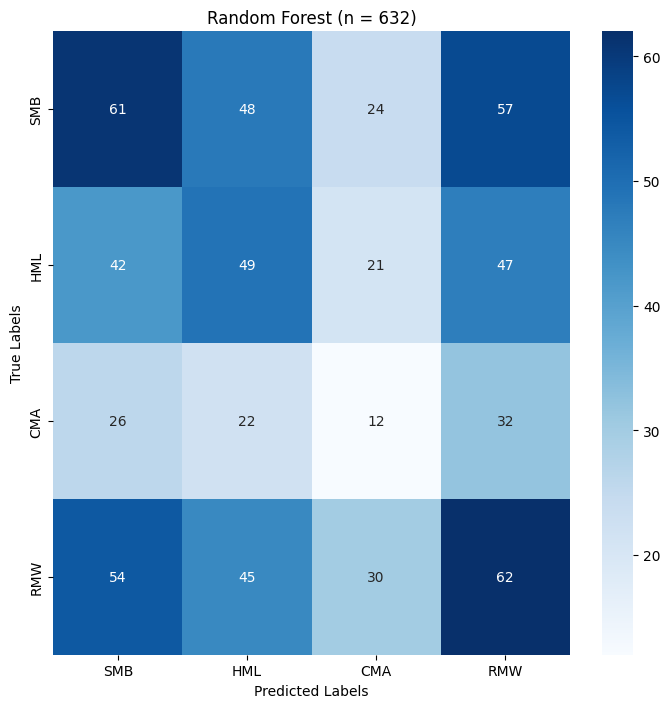

Model,Accuracy,Precision,Recall,F1 Score,Samples
Random Forest,0.2911,0.2901,0.2911,0.2905,632


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML

# Use FACTORS directly as labels for the confusion matrix axes.
labels = FACTORS

# Determine how many models we have.
num_models = len(results_dfs)

# Create a figure with 1 row and num_models columns.
fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(8 * num_models, 8))
if num_models == 1:
    axes = [axes]  # Make it iterable

# A dictionary to hold overall metrics for each model.
overall_metrics_dict = {}

# Iterate over the dictionary and plot the overall confusion matrix for each model.
for i, (model_key, results_df) in enumerate(results_dfs.items()):
    # Extract true and predicted winners.
    all_true = results_df['Actual_Winner']
    all_pred = results_df['Predicted_Winner']

    # Compute the overall confusion matrix.
    cm_total = confusion_matrix(all_true, all_pred, labels=labels)

    # Plot the confusion matrix for this model.
    sns.heatmap(cm_total, annot=True, fmt='d', cmap="Blues",
                xticklabels=labels, yticklabels=labels, ax=axes[i])
    axes[i].set_xlabel("Predicted Labels")
    axes[i].set_ylabel("True Labels")
    axes[i].set_title(f"{model_key} (n = {len(all_true)})")

    # Compute overall performance metrics.
    overall_metrics_dict[model_key] = {
         "Accuracy": accuracy_score(all_true, all_pred),
         "Precision": precision_score(all_true, all_pred, average='weighted', zero_division=0),
         "Recall": recall_score(all_true, all_pred, average='weighted', zero_division=0),
         "F1 Score": f1_score(all_true, all_pred, average='weighted', zero_division=0),
         "Samples": len(all_true)
    }

plt.tight_layout(pad=4.0)
plt.show()

# Build an HTML table summarizing overall performance metrics for all models.
html_overall = "<h3>Overall Performance Metrics Summary (Side by Side)</h3>"
html_overall += "<table border='1' cellpadding='5'><tr><th>Model</th><th>Accuracy</th><th>Precision</th><th>Recall</th><th>F1 Score</th><th>Samples</th></tr>"

for model_key, metrics in overall_metrics_dict.items():
    html_overall += f"<tr><td>{model_key}</td><td>{metrics['Accuracy']:.4f}</td><td>{metrics['Precision']:.4f}</td>"
    html_overall += f"<td>{metrics['Recall']:.4f}</td><td>{metrics['F1 Score']:.4f}</td><td>{metrics['Samples']}</td></tr>"

html_overall += "</table>"

# Display the metrics table.
display(HTML(html_overall))


##Feature importance

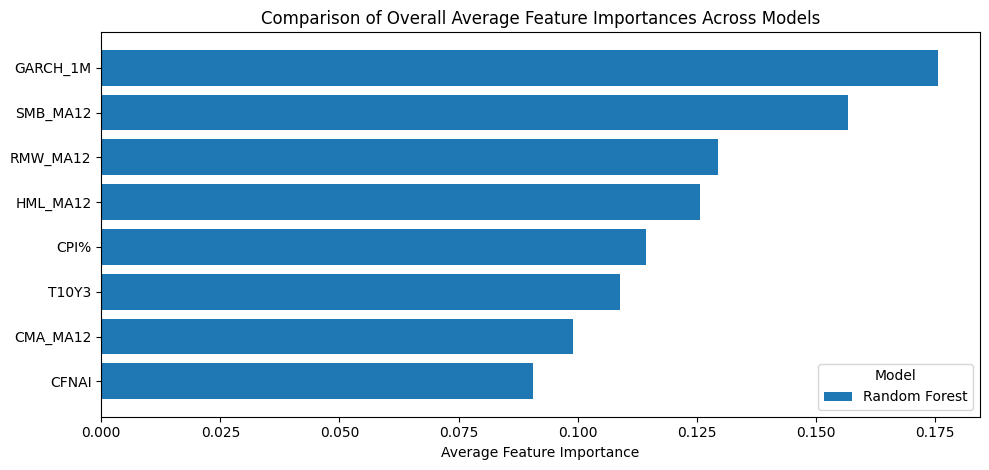

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume FEATURES is defined (e.g., FEATURES = ['CPI%', 'T10YFF', 'LEI%', 'Amihud', 'GARCH_1M'])
# and results_dfs is a dictionary with keys like "RF", "GB", (and maybe "Hybrid")
# where each value is a DataFrame that has a column "Feature_Importances" (an array).

# 1. Compute overall average feature importances for each model.
model_importances = {}
for model_key, df in results_dfs.items():
    # Stack the arrays from the "Feature_Importances" column and average over predictions.
    model_importances[model_key] = np.vstack(df['Feature_Importances'].values).mean(axis=0)

# 2. Create a DataFrame from the computed importances.
# Rows: features, Columns: model keys.
importance_df = pd.DataFrame(model_importances, index=FEATURES)

# Optional: sort features by overall mean importance (averaged across models) so that
# the most important features appear on top.
importance_df['Mean'] = importance_df.mean(axis=1)
importance_df = importance_df.sort_values(by='Mean', ascending=False)
sorted_features = importance_df.index.tolist()
importance_df = importance_df.drop(columns=['Mean'])

# 3. Plot a grouped horizontal bar chart.
models = importance_df.columns.tolist()
n_models = len(models)
n_features = len(sorted_features)
y = np.arange(n_features)  # base positions for each feature group
bar_height = 0.8 / n_models  # total group thickness is 0.8

fig, ax = plt.subplots(figsize=(10, max(4, n_features * 0.6)))
for i, model in enumerate(models):
    # Calculate an offset for each model in the group.
    offset = (i - n_models/2) * bar_height + bar_height/2
    ax.barh(y + offset, importance_df.loc[sorted_features, model], height=bar_height, label=model)

ax.set_yticks(y)
ax.set_yticklabels(sorted_features)
ax.invert_yaxis()  # so the top feature is at the top
ax.set_xlabel("Average Feature Importance")
ax.set_title("Comparison of Overall Average Feature Importances Across Models")
ax.legend(title="Model")
plt.tight_layout()
plt.show()


##Allocation chart

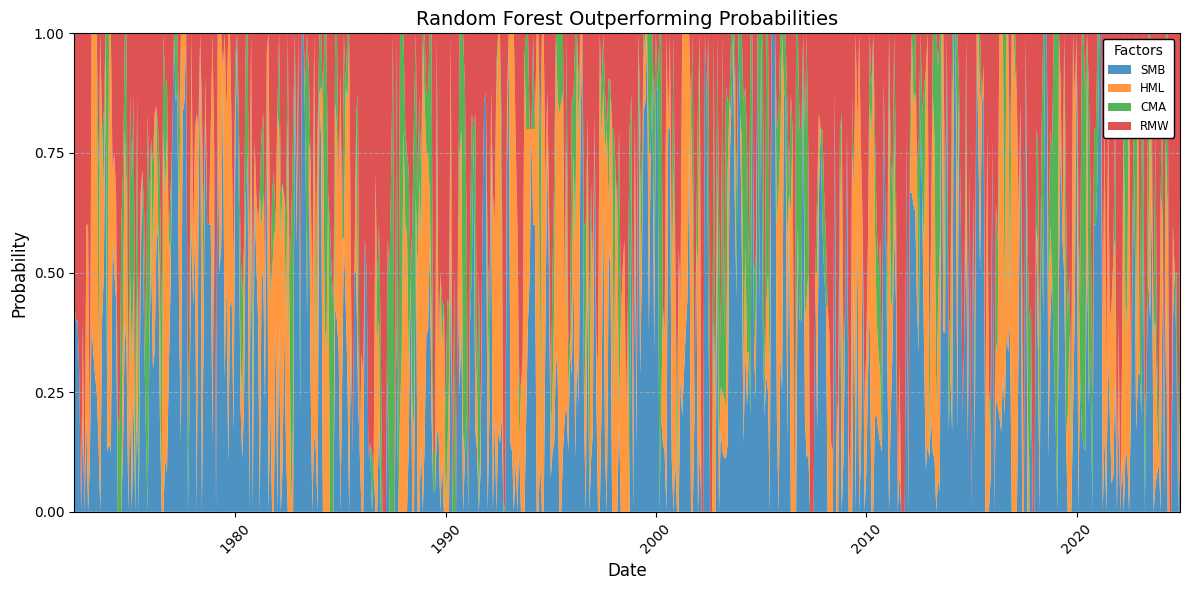

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Determine how many models to plot
num_models = len(results_dfs)

# Create subplots: one row per model, sharing the x-axis
fig, axes = plt.subplots(nrows=num_models, ncols=1, figsize=(12, 6 * num_models), sharex=True)
if num_models == 1:
    axes = [axes]  # Ensure iterable if only one model

# Loop through each model's result dataframe
for ax, (model_key, df_model) in zip(axes, results_dfs.items()):
    df_temp = df_model.copy()

    # 1) Convert Predicted_month to datetime (robust handling)
    df_temp["Predicted_month"] = pd.to_datetime(df_temp["Predicted_month"], errors='coerce')

    # 2) Drop rows with invalid dates
    df_temp = df_temp.dropna(subset=["Predicted_month"])
    df_temp = df_temp.sort_values("Predicted_month").reset_index(drop=True)

    # 3) Stack probabilities
    full_probs = np.vstack(df_temp["Predicted_Probabilities"].values)
    probability_df = pd.DataFrame(full_probs, columns=FACTORS)
    probability_df["Date"] = df_temp["Predicted_month"]

    # 4) Sort by date again (just in case)
    probability_df = probability_df.sort_values("Date").reset_index(drop=True)

    # 5) Plot stackplot
    ax.stackplot(
        probability_df["Date"],
        [probability_df[col] for col in FACTORS],
        labels=FACTORS,
        alpha=0.8
    )

    # ✅ Legend: top right, inside chart, solid white background
    ax.legend(
        loc="upper right",
        fontsize="small",
        title="Factors",
        frameon=True,
        framealpha=1.0,      # fully opaque
        facecolor='white',   # solid background
        edgecolor='black'    # optional: to match style
    )

    # Set title, axes, and formatting
    ax.set_title(f"{model_key} Outperforming Probabilities", fontsize=14)
    ax.set_ylabel("Probability", fontsize=12)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Trim x-axis to data range
    ax.set_xlim(probability_df["Date"].min(), probability_df["Date"].max())

# Final x-axis label and formatting
plt.xlabel("Date", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##Factor weight analysis

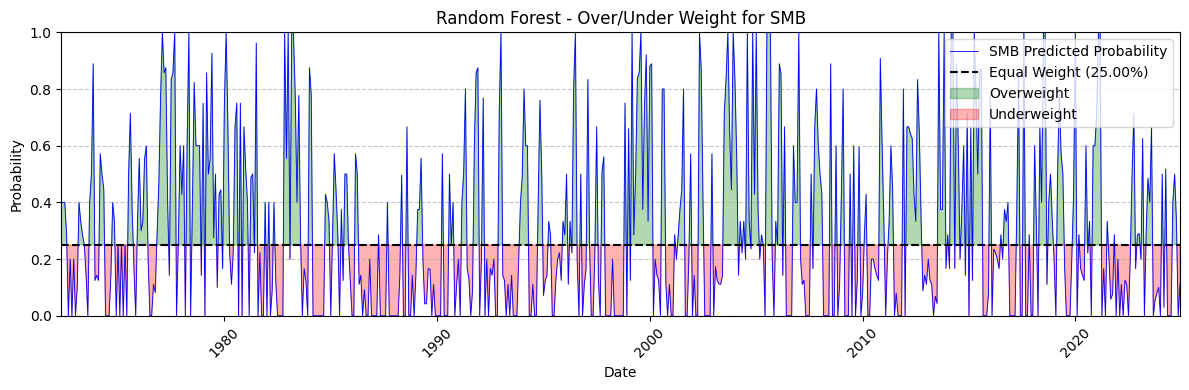

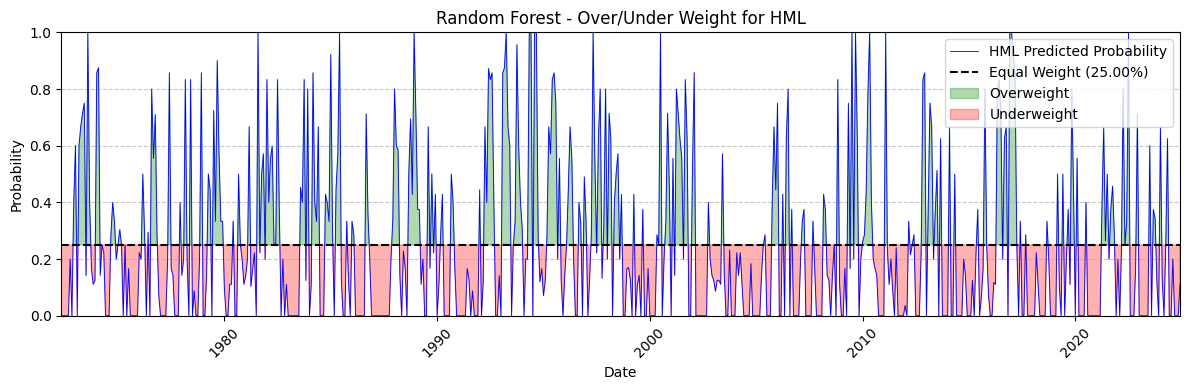

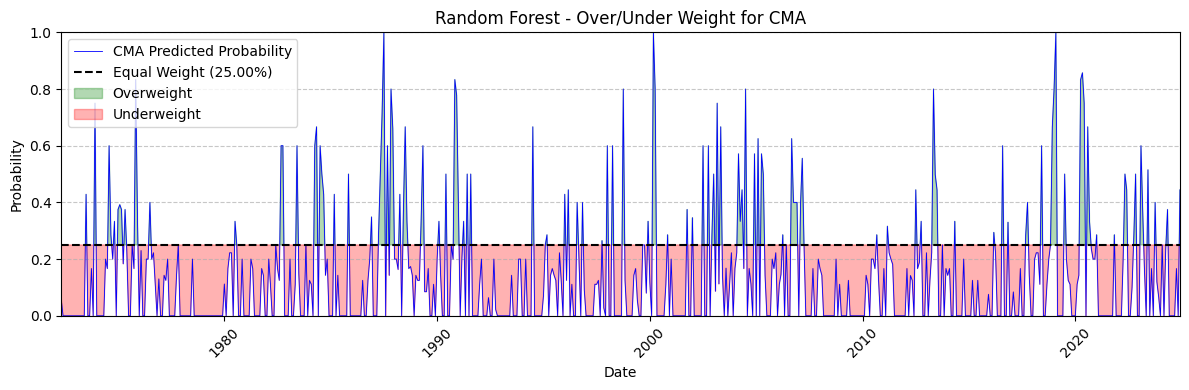

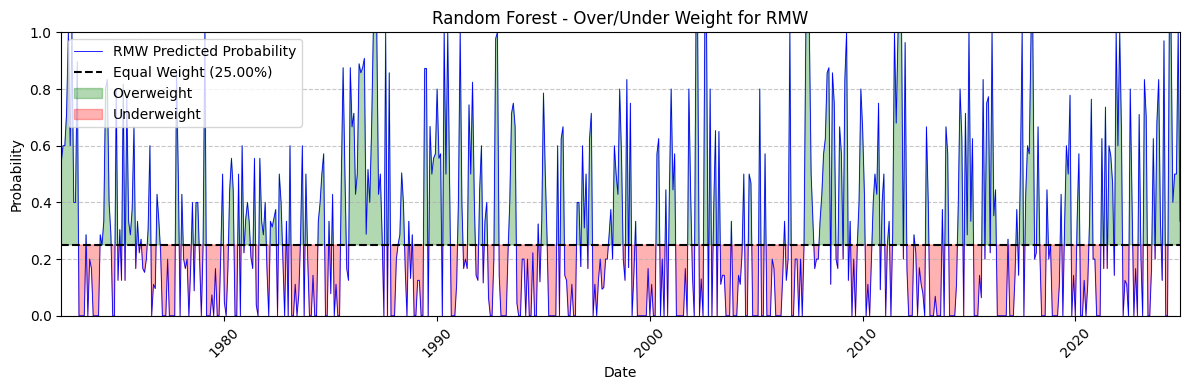

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Toggle:
combine_all_models = False  # Set to True to combine all models into the same charts; False for individual charts per model

# Set the date range for viewing.
start_date = pd.to_datetime("1968-07-30")
end_date   = pd.to_datetime("2024-11-30")

# Define static equal weight value.
equal_weight = 1 / len(FACTORS)  # e.g., for 5 factors equal_weight = 0.20

if combine_all_models:
    # Combined charts: One set of subplots (one per factor) for all models.
    n_factors = len(FACTORS)
    fig, axs = plt.subplots(n_factors, 1, figsize=(12, 4 * n_factors), sharex=False)
    if n_factors == 1:
        axs = [axs]  # ensure axs is iterable

    for i, factor in enumerate(FACTORS):
        ax = axs[i]
        min_dates = []
        max_dates = []

        # Loop through each model's results
        for model_key, df_model in results_dfs.items():
            df_temp = df_model.copy()
            df_temp["Predicted_month"] = pd.to_datetime(df_temp["Predicted_month"], errors='coerce')
            df_temp = df_temp.dropna(subset=["Predicted_month"]).sort_values("Predicted_month").reset_index(drop=True)

            # Stack predicted probabilities into a DataFrame.
            full_probs = np.vstack(df_temp["Predicted_Probabilities"].values)
            probability_df = pd.DataFrame(full_probs, columns=FACTORS)
            probability_df["Date"] = df_temp["Predicted_month"]

            # Filter to desired date range.
            mask = (probability_df["Date"] >= start_date) & (probability_df["Date"] <= end_date)
            filtered_df = probability_df.loc[mask].reset_index(drop=True)

            if filtered_df.empty:
                continue

            ax.plot(filtered_df["Date"], filtered_df[factor],
                    label=f"{factor}_{model_key}", linewdth=0.6)

            min_dates.append(filtered_df["Date"].min())
            max_dates.append(filtered_df["Date"].max())

        # Set x-axis limits to exactly the data span (if any data exist)
        if min_dates and max_dates:
            ax.set_xlim(min(min_dates), max(max_dates))

        # Draw the static equal weight horizontal line.
        ax.axhline(equal_weight, color='black', linestyle='--',
                   label=f"Equal Weight ({equal_weight:.2%})")

        ax.set_title(f"{factor} Predicted Probabilities Across Models", fontsize=14)
        ax.set_ylabel("Probability", fontsize=12)
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.legend(loc='best', fontsize='small')

    plt.xlabel("Date", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    # Separate charts: Loop over each model and for each factor create individual charts.
    for model_key, df_model in results_dfs.items():
        for factor in FACTORS:
            df_temp = df_model.copy()
            df_temp["Predicted_month"] = pd.to_datetime(df_temp["Predicted_month"], errors='coerce')
            df_temp = df_temp.dropna(subset=["Predicted_month"]).sort_values("Predicted_month").reset_index(drop=True)

            full_probs = np.vstack(df_temp["Predicted_Probabilities"].values)
            probability_df = pd.DataFrame(full_probs, columns=FACTORS)
            probability_df["Date"] = df_temp["Predicted_month"]

            # Filter to desired date range.
            mask = (probability_df["Date"] >= start_date) & (probability_df["Date"] <= end_date)
            filtered_df = probability_df.loc[mask].reset_index(drop=True)

            if filtered_df.empty:
                continue

            plt.figure(figsize=(12, 4))
            plt.plot(filtered_df["Date"], filtered_df[factor],
                     label=f"{factor} Predicted Probability", color='blue', linewidth=0.6)

            plt.axhline(equal_weight, color='black', linestyle='--',
                        label=f"Equal Weight ({equal_weight:.2%})")

            plt.fill_between(filtered_df["Date"],
                             filtered_df[factor],
                             equal_weight,
                             where=(filtered_df[factor] > equal_weight),
                             interpolate=True, color='green', alpha=0.3, label='Overweight')
            plt.fill_between(filtered_df["Date"],
                             filtered_df[factor],
                             equal_weight,
                             where=(filtered_df[factor] < equal_weight),
                             interpolate=True, color='red', alpha=0.3, label='Underweight')

            plt.title(f"{model_key} - Over/Under Weight for {factor}")
            plt.xlabel("Date")
            plt.ylabel("Probability")
            plt.ylim(0, 1)
            # Set x-axis limits to exactly where data exists.
            plt.xlim(filtered_df["Date"].min(), filtered_df["Date"].max())
            plt.legend(loc='best')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()


##Total outperforming probabilities

Model,SMB,HML,CMA,RMW
Random Forest,0.3059,0.2509,0.1414,0.3018


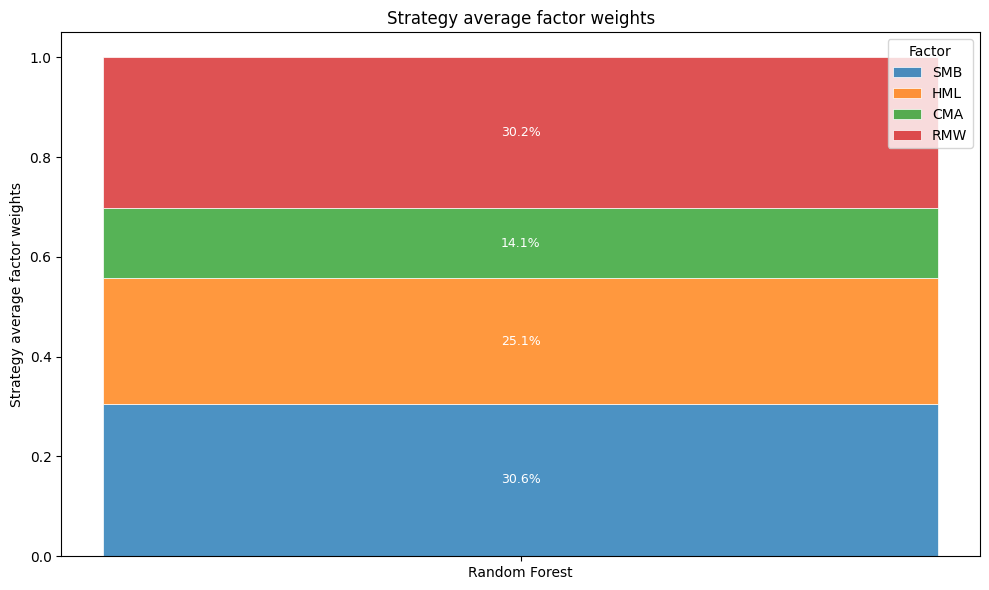

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# ----------------------------------------------------
# 1. Compute average predicted probabilities per model
# ----------------------------------------------------
avg_probs_dict = {}
avg_highest_factor_weight_dict = {}

for model_key, df_model in results_dfs.items():
    full_probs = np.vstack(df_model["Predicted_Probabilities"].values)

    # 1a. Compute the average probabilities across all rows
    avg = full_probs.mean(axis=0)
    avg_probs_dict[model_key] = pd.Series(avg, index=FACTORS)

    # 1b. Compute the average of the highest weight factor
    #     (for each time step, pick the max factor weight, then average those)
    avg_highest_factor_weight_dict[model_key] = full_probs.max(axis=1).mean()

# Create a DataFrame where rows = models, columns = factors
avg_probs_df = pd.DataFrame(avg_probs_dict).T
avg_probs_df.index.name = "Model"
avg_probs_df = avg_probs_df.round(4)

# ----------------------------------------------------
# 2. Generate consistent factor colors from stackplot
# ----------------------------------------------------
# Use a dummy stackplot to extract the assigned factor colors
_, ax_dummy = plt.subplots()
dummy_data = np.random.rand(10, len(FACTORS))
dummy_dates = pd.date_range("2000-01-01", periods=10)
stack = ax_dummy.stackplot(dummy_dates, dummy_data.T, labels=FACTORS, alpha=0.8)
plt.close()  # We don’t want to display this

# Build color map: factor name → RGBA color
factor_colors = {factor: poly.get_facecolor()[0] for factor, poly in zip(FACTORS, stack)}

# ----------------------------------------------------
# 3. Display HTML Table of average probabilities
# ----------------------------------------------------
html_table = avg_probs_df.reset_index().to_html(index=False, classes="table table-striped table-bordered", border=0)
display(HTML("<h3>Average Outperforming Probabilities by Model</h3>" + html_table))

# ----------------------------------------------------
# 4. Print average of the highest factor weight by model
# ----------------------------------------------------
display(HTML("<h4>Average of the Highest Factor Weight by Model</h4>"))
for model_key, avg_highest in avg_highest_factor_weight_dict.items():
    display(HTML(f"<p><strong>{model_key}:</strong> {avg_highest:.4f}</p>"))

# ----------------------------------------------------
# 5. Stacked Bar Chart with Consistent Colors and Labels
# ----------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

bottom = np.zeros(len(avg_probs_df))
x = np.arange(len(avg_probs_df))

for factor in FACTORS:
    values = avg_probs_df[factor].values
    bars = ax.bar(x, values, bottom=bottom,
                  label=factor,
                  color=factor_colors[factor],
                  edgecolor="white",
                  linewidth=0.5)

    # Centered labels
    for bar, val in zip(bars, values):
        if val > 0.03:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{val * 100:.1f}%",
                ha="center", va="center", fontsize=9, color="white"
            )

    bottom += values

# Final touches
ax.set_xticks(x)
ax.set_xticklabels(avg_probs_df.index)
ax.set_ylabel("Strategy average factor weights")
ax.set_title("Strategy average factor weights")
ax.legend(title="Factor", loc="upper right")
plt.tight_layout()
plt.show()


#Return data

In [ ]:
import pandas as pd
from IPython.display import display

# ==============================================================================
# Step 0: Define column orders based on your requirements
# ------------------------------------------------------------------------------
# Common columns that are identical across all models.
common_cols = ['Predicted_month', 'Mkt', 'RF', 'Mkt-RF', 'Us_standard'] + FACTORS + ['Equal_Weight_Return', 'Actual_Winner']

# Model-specific columns that will be renamed.
model_specific_cols = ['Allocated_Return', 'Predicted_Winner']

# ==============================================================================
# Step 1. Build a base common DataFrame from one model's merged results.
# ------------------------------------------------------------------------------
# Take the first model as the base to extract common columns.
base_key, base_df = list(results_dfs.items())[0]
base_df = base_df.copy()
base_df['Predicted_month'] = pd.to_datetime(base_df['Predicted_month'], errors='coerce')

# Merge with df_sorted (the master DataFrame sorted by date) on date.
base_df_local = base_df.merge(df_sorted, left_on='Predicted_month', right_on='Date', how='left')
common_df = base_df_local[[c for c in common_cols if c in base_df_local.columns]].copy()

# ==============================================================================
# Step 2. Process each model individually to extract the model-specific columns.
# ------------------------------------------------------------------------------
# We'll assign a new display name using numbering such that each model gets:
# "ML{number}: {Model Name}"
model_dfs = []         # Will hold one DataFrame per model.
new_model_names = []   # To store new model names.
for i, (model_key, df_model) in enumerate(results_dfs.items(), 1):
    new_model_name = f"ML{i}: {model_key}"  # New display name.
    new_model_names.append(new_model_name)

    df_temp = df_model.copy()
    df_temp['Predicted_month'] = pd.to_datetime(df_temp['Predicted_month'], errors='coerce')

    # Merge with df_sorted on 'Predicted_month' = 'Date'
    df_temp_local = df_temp.merge(df_sorted, left_on='Predicted_month', right_on='Date', how='left')

    # Keep only the 'Predicted_month' plus the model-specific columns.
    subset_cols = ['Predicted_month'] + [col for col in model_specific_cols if col in df_temp_local.columns]
    df_subset = df_temp_local[subset_cols].copy()

    # Rename model-specific columns with the new model name.
    rename_dict = {}
    for col in model_specific_cols:
        if col in df_subset.columns:
            rename_dict[col] = f"{new_model_name} {col}"
    df_subset.rename(columns=rename_dict, inplace=True)

    model_dfs.append(df_subset)

# ==============================================================================
# Step 3. Merge each model-specific DataFrame with the common DataFrame.
# ------------------------------------------------------------------------------
combined_df = common_df.copy()
for df_sub in model_dfs:
    combined_df = combined_df.merge(df_sub, on='Predicted_month', how='left')

# ==============================================================================
# Step 4. Reorder the columns to match the desired order.
# ------------------------------------------------------------------------------
benchmark_cols = ['Mkt', 'RF', 'Mkt-RF', 'Us_standard']
common_order = ['Predicted_month'] + benchmark_cols + FACTORS
# Model-specific allocated return columns.
allocated_cols = [f"{name} Allocated_Return" for name in new_model_names]
# Model-specific predicted winner columns.
predicted_cols = [f"{name} Predicted_Winner" for name in new_model_names]

final_order = common_order + ['Equal_Weight_Return'] + allocated_cols + ['Actual_Winner'] + predicted_cols
final_order = [col for col in final_order if col in combined_df.columns]

combined_df = combined_df[final_order].sort_values('Predicted_month').reset_index(drop=True)

# ==============================================================================
# Step 5. Display the final combined results table.
# ------------------------------------------------------------------------------
display(combined_df)
print("\nFirst date in 'Predicted_month':", pd.to_datetime(combined_df['Predicted_month']).min())
print("Last date in 'Predicted_month':", pd.to_datetime(combined_df['Predicted_month']).max())


,Predicted_month,Mkt,RF,Mkt-RF,SMB,HML,CMA,RMW,Equal_Weight_Return,ML1: Random Forest Allocated_Return,Actual_Winner,ML1: Random Forest Predicted_Winner
0,1972-04-30,0.0058,0.0029,0.0029,0.0023,0.0012,-0.0103,-0.0042,-0.002750,-0.001954,SMB,RMW
1,1972-05-30,0.0155,0.0030,0.0125,-0.0310,-0.0270,-0.0195,0.0234,-0.013525,0.001640,RMW,RMW
2,1972-06-30,-0.0214,0.0029,-0.0243,-0.0043,-0.0248,-0.0036,0.0188,-0.003475,0.009560,RMW,RMW
3,1972-07-30,-0.0049,0.0031,-0.0080,-0.0277,0.0066,-0.0066,0.0114,-0.004075,0.000229,RMW,RMW
4,1972-08-30,0.0355,0.0029,0.0326,-0.0348,0.0454,0.0285,-0.0196,0.004875,-0.019600,HML,RMW
...,...,...,...,...,...,...,...,...,...,...,...,...
627,2024-07-30,0.0169,0.0045,0.0124,0.0828,0.0574,0.0043,0.0022,0.036675,0.045480,SMB,RMW
628,2024-08-30,0.0209,0.0048,0.0161,-0.0365,-0.0113,0.0086,0.0085,-0.007675,-0.014000,CMA,RMW
629,2024-09-30,0.0214,0.0040,0.0174,-0.0102,-0.0259,-0.0026,0.0004,-0.009575,-0.003633,RMW,RMW
630,2024-10-30,-0.0058,0.0039,-0.0097,-0.0088,0.0089,0.0103,-0.0138,-0.000850,-0.013800,CMA,RMW



First date in 'Predicted_month': 1972-04-30 00:00:00
Last date in 'Predicted_month': 2024-11-30 00:00:00


In [ ]:
import pandas as pd
import numpy as np
import textwrap

# Define your date range
start_date = pd.to_datetime('1950-01-01')
end_date   = pd.to_datetime('2024-12-30')

# Create a filtered copy of combined_df (so the original data isn't lost)
filtered_df = combined_df.loc[
    (combined_df['Predicted_month'] >= start_date) &
    (combined_df['Predicted_month'] <= end_date)
].copy()

# Ensure "Year" column exists in filtered_df
if 'Year' not in filtered_df.columns:
    filtered_df['Year'] = filtered_df['Predicted_month'].dt.year

# Identify ML return columns and create a name map to remove "Allocated_Return"
ml_return_cols = [c for c in filtered_df.columns if 'Allocated_Return' in c]
ml_name_map = {ml: ml.replace("Allocated_Return", "").strip() for ml in ml_return_cols}

# Helper: Compute annual metrics (RF-adjusted)
def compute_annual_metrics(returns: pd.Series, rf: pd.Series):
    returns = returns.dropna()
    if returns.empty:
        return np.nan, np.nan, np.nan
    rf = rf.reindex(returns.index)
    ann_ret = (1 + returns).prod() - 1
    ann_rf  = (1 + rf).prod() - 1
    ann_ex_ret = ann_ret - ann_rf
    ann_vol = (returns - rf).std() * np.sqrt(12)
    ann_sharpe = ann_ex_ret / ann_vol if ann_vol else np.nan
    return ann_ret, ann_vol, ann_sharpe

# Build df_metrics (raw values) and df_excess (excess over Equal Weight)
metrics_rows, excess_rows = [], []
for year, grp in filtered_df.groupby('Year'):
    ew_ret, ew_vol, ew_sharpe = compute_annual_metrics(grp['Equal_Weight_Return'], grp['RF'])
    row_m = {'Year': year,
             'Equal_Weight Return': ew_ret,
             'Equal_Weight Vol':    ew_vol,
             'Equal_Weight Sharpe': ew_sharpe}
    row_e = {'Year': year}

    for ml in ml_return_cols:
        ml_short = ml_name_map[ml]
        ml_ret, ml_vol, ml_sharpe = compute_annual_metrics(grp[ml], grp['RF'])
        row_m[f"{ml_short} Return"]  = ml_ret
        row_m[f"{ml_short} Vol"]     = ml_vol
        row_m[f"{ml_short} Sharpe"]  = ml_sharpe

        row_e[f"{ml_short} Excess Return"]  = ml_ret - ew_ret
        row_e[f"{ml_short} Excess Vol"]     = ml_vol - ew_vol
        row_e[f"{ml_short} Excess Sharpe"]  = ml_sharpe - ew_sharpe

    metrics_rows.append(row_m)
    excess_rows.append(row_e)

df_metrics = pd.DataFrame(metrics_rows).set_index('Year').sort_index()
df_excess  = pd.DataFrame(excess_rows).set_index('Year').sort_index()

# Function: Insert newline breaks for column names longer than max_width characters.
def wrap_colname(colname, max_width=15):
    lines = textwrap.wrap(colname, width=max_width)
    return "\n".join(lines)

# Apply wrapping to all column names
df_metrics.columns = [wrap_colname(col) for col in df_metrics.columns]
df_excess.columns  = [wrap_colname(col) for col in df_excess.columns]

# Function: Style dataframe to enable multiline headers and format numbers with a max of 3 decimals.
def style_with_wrapping_and_format(df):
    styled = df.style.set_table_styles([
        {
            'selector': 'th',
            'props': [
                ('white-space', 'pre-wrap'),  # allow multiline
                ('word-wrap', 'break-word')   # break long words
            ]
        }
    ]).format(lambda x: f"{x:.3f}" if isinstance(x, float) else x)
    return styled

# Display the raw metrics and excess metrics with formatted output.
display(style_with_wrapping_and_format(df_metrics))
display(style_with_wrapping_and_format(df_excess))

# -----------------------------------------------------------------
# Summary: Count how often each ML strategy "beats" Equal Weight.
#  - Excess Return is "better" if > 0.
#  - Excess Volatility is "better" if < 0.
#  - Excess Sharpe is "better" if > 0.
#
# Average excess metrics are now calculated from all observations.
# -----------------------------------------------------------------
summary_rows = []
total_years = len(df_excess)

def w(ml_short, suffix):
    return wrap_colname(f"{ml_short} {suffix}")

for ml in ml_return_cols:
    ml_short = ml_name_map[ml]
    ret_series    = df_excess[w(ml_short, "Excess Return")]
    vol_series    = df_excess[w(ml_short, "Excess Vol")]
    sharpe_series = df_excess[w(ml_short, "Excess Sharpe")]

    ret_pos_count    = (ret_series > 0).sum()
    vol_neg_count    = (vol_series < 0).sum()
    sharpe_pos_count = (sharpe_series > 0).sum()

    # Average excess metrics now computed over all observations:
    avg_ret    = ret_series.mean()
    avg_vol    = vol_series.mean()
    avg_sharpe = sharpe_series.mean()

    summary_rows.append({
        "Strategy": ml_short,
        "Excess Return (Positive) Count": f"{ret_pos_count}/{total_years}",
        "Avg Excess Return":   avg_ret,
        "Excess Vol (Negative) Count":    f"{vol_neg_count}/{total_years}",
        "Avg Excess Vol":      avg_vol,
        "Excess Sharpe (Positive) Count": f"{sharpe_pos_count}/{total_years}",
        "Avg Excess Sharpe":   avg_sharpe
    })

summary_df = pd.DataFrame(summary_rows)
summary_df.columns = [wrap_colname(col) for col in summary_df.columns]

display(style_with_wrapping_and_format(summary_df))


,Equal_Weight Return,Equal_Weight Vol,Equal_Weight Sharpe,ML1: Random Forest Return,ML1: Random Forest Vol,ML1: Random Forest Sharpe
Year,,,,,,
1972,-0.022,0.027,-1.914,0.002,0.031,-0.904
1973,-0.012,0.026,-3.177,0.014,0.076,-0.730
1974,0.087,0.076,0.085,0.118,0.114,0.335
1975,0.058,0.058,-0.006,0.034,0.045,-0.532
1976,0.093,0.054,0.781,0.130,0.065,1.224
1977,0.084,0.028,1.182,0.197,0.052,2.821
1978,0.057,0.039,-0.385,0.016,0.082,-0.690
1979,0.031,0.026,-2.786,0.021,0.056,-1.490
1980,-0.034,0.045,-3.259,-0.005,0.049,-2.413


,ML1: Random Forest Excess Return,ML1: Random Forest Excess Vol,ML1: Random Forest Excess Sharpe
Year,,,
1972,0.025,0.003,1.010
1973,0.026,0.050,2.447
1974,0.032,0.038,0.250
1975,-0.024,-0.013,-0.526
1976,0.037,0.010,0.443
1977,0.113,0.024,1.639
1978,-0.041,0.043,-0.305
1979,-0.010,0.029,1.296
1980,0.029,0.004,0.846


,Strategy,Excess Return (Positive) Count,Avg Excess Return,Excess Vol (Negative) Count,Avg Excess Vol,Excess Sharpe (Positive) Count,Avg Excess Sharpe
0,ML1: Random Forest,33/53,0.020,4/53,0.021,37/53,0.532


##Cumulative returns table

In [ ]:
import pandas as pd
import numpy as np

# ---------------------------------------------------------------------
# PRELIMINARY: Use the merged multi-model table (combined_df)
# ---------------------------------------------------------------------
start_date = pd.to_datetime('1950-01-01')
end_date   = pd.to_datetime('2024-12-30')
df_filtered = combined_df[(combined_df['Predicted_month'] >= start_date) &
                            (combined_df['Predicted_month'] <= end_date)].copy()

# Rename benchmark column if present (using the first element of BENCHMARK)
rename_dict = {}
if BENCHMARK[0] in df_filtered.columns:
    rename_dict[BENCHMARK[0]] = 'Benchmark Return'
df_filtered.rename(columns=rename_dict, inplace=True)

# ---------------------------------------------------------------------
# Remove RF from factors (we exclude it)
factors_to_use = [fac for fac in FACTORS if fac.upper() != 'RF']

# Define possible benchmark columns (for cumulative returns).
possible_bench = ["Benchmark Return", "Mkt", "Mkt-RF", "Us_standard"]
benchmark_cols = [col for col in possible_bench if col in df_filtered.columns]

# ---------------------------------------------------------------------
# Calculate Equal-Weighted Returns based on factors_to_use.
if all(f in df_filtered.columns for f in factors_to_use):
    df_filtered['Equal Factor Weight Strategy Return'] = df_filtered[factors_to_use].mean(axis=1)
    equal_ret_col_list = ['Equal Factor Weight Strategy Return']
else:
    equal_ret_col_list = []

# ---------------------------------------------------------------------
# Predicted Winner Weighted Strategy Return:
# Use the base model's predicted winner column using new naming.
base_model_key = list(results_dfs.keys())[0]
base_model_new = f"ML1: {base_model_key}"  # First model is ML1.
base_model_pred_col = f"{base_model_new} Predicted_Winner"
if base_model_pred_col in df_filtered.columns:
    df_filtered['Predicted_Winner'] = df_filtered[base_model_pred_col]

def calc_winner_strategy(row):
    pred = row['Predicted_Winner']
    if pred in factors_to_use:
        other_factors = [f for f in factors_to_use if f != pred]
        if other_factors:
            return 0.5 * row[pred] + 0.5 * row[other_factors].mean()
        else:
            return row[pred]
    else:
        return row[factors_to_use].mean()

df_filtered['Predicted Winner Weighted Strategy Return'] = df_filtered.apply(calc_winner_strategy, axis=1)

# ---------------------------------------------------------------------
# Compute cumulative returns for each return series.
# We'll work on a copy for cumulative computations.
cum = df_filtered.copy()

# 1. For each model's allocated return (using new names).
allocated_cum_cols = []
new_model_names = [f"ML{i}: {model_key}" for i, model_key in enumerate(results_dfs.keys(), 1)]
for name in new_model_names:
    col_alloc = f"{name} Allocated_Return"
    if col_alloc in cum.columns:
        new_cum_col = col_alloc.replace("Allocated_Return", "Cumulative Allocated Return")
        cum[new_cum_col] = (1 + cum[col_alloc]).cumprod() - 1
        allocated_cum_cols.append(new_cum_col)

# 2. For equal factor weight returns.
if 'Equal Factor Weight Strategy Return' in cum.columns:
    cum['Equal Factor Weight Cumulative Return'] = (1 + cum['Equal Factor Weight Strategy Return']).cumprod() - 1
    equal_cum_cols = ['Equal Factor Weight Cumulative Return']
else:
    equal_cum_cols = []

# 3. For each benchmark column.
bench_cum_cols = []
# If "Benchmark Return" is available, use the actual benchmark name from BENCHMARK[0].
if "Benchmark Return" in cum.columns:
    new_bench_col = f"{BENCHMARK[0]} Cumulative Return"
    cum[new_bench_col] = (1 + cum["Benchmark Return"]).cumprod() - 1
    bench_cum_cols.append(new_bench_col)
# Process any other benchmark columns
for col in benchmark_cols:
    if col != "Benchmark Return":
        new_col = col + " Cumulative Return"
        cum[new_col] = (1 + cum[col]).cumprod() - 1
        bench_cum_cols.append(new_col)

# 4. For Predicted Winner Weighted Strategy Return.
if 'Predicted Winner Weighted Strategy Return' in cum.columns:
    cum['Predicted Winner Weighted Cumulative Return'] = (1 + cum['Predicted Winner Weighted Strategy Return']).cumprod() - 1

# 5. For each factor in factors_to_use: compute cumulative returns.
factor_cum_cols = []
for fac in factors_to_use:
    if fac in cum.columns:
        new_name = fac + " Cumulative"
        cum[new_name] = (1 + cum[fac]).cumprod() - 1
        factor_cum_cols.append(new_name)

# ---------------------------------------------------------------------
# Build the final cumulative returns table.
# Final order:
#   a. Common columns: Predicted_month, then benchmark cumulative returns, then factor cumulative returns.
#   b. Then Equal Factor Weight Cumulative Return.
#   c. Then each model's Cumulative Allocated Return.
#   d. Then Predicted Winner Weighted Cumulative Return.
# ---------------------------------------------------------------------
final_common_order = ['Predicted_month'] + bench_cum_cols + factor_cum_cols
final_order = final_common_order + equal_cum_cols + allocated_cum_cols
if 'Predicted Winner Weighted Cumulative Return' in cum.columns:
    final_order.append('Predicted Winner Weighted Cumulative Return')

final_order = [col for col in final_order if col in cum.columns]
cumulative_table = cum[final_order].sort_values('Predicted_month').reset_index(drop=True)

# ---------------------------------------------------------------------
# Display the Final Cumulative Returns Table.
# ---------------------------------------------------------------------
print("Cumulative Returns Table:")
display(cumulative_table)
print("\nFirst date in 'Predicted_month':", pd.to_datetime(cumulative_table['Predicted_month']).min())
print("Last date in 'Predicted_month':", pd.to_datetime(cumulative_table['Predicted_month']).max())


Cumulative Returns Table:


,Predicted_month,Mkt Cumulative Return,Mkt-RF Cumulative Return,SMB Cumulative,HML Cumulative,CMA Cumulative,RMW Cumulative,Equal Factor Weight Cumulative Return,ML1: Random Forest Cumulative Allocated Return,Predicted Winner Weighted Cumulative Return
0,1972-04-30,0.005800,0.002900,0.002300,0.001200,-0.010300,-0.004200,-0.002750,-0.001954,-0.003233
1,1972-05-30,0.021390,0.015436,-0.028771,-0.025832,-0.029599,0.019102,-0.016238,-0.000317,-0.004446
2,1972-06-30,-0.000468,-0.009239,-0.032948,-0.049992,-0.033093,0.038261,-0.019656,0.009240,-0.000514
3,1972-07-30,-0.005366,-0.017165,-0.059735,-0.043722,-0.039474,0.050097,-0.023651,0.009471,0.000569
4,1972-08-30,0.029944,0.014875,-0.092456,-0.000307,-0.012099,0.029515,-0.018892,-0.010315,-0.002716
...,...,...,...,...,...,...,...,...,...,...
627,2024-07-30,218.141845,22.118468,0.787200,3.728210,4.070783,5.019069,3.684019,11.657990,5.956116
628,2024-08-30,222.721910,22.490675,0.721967,3.674781,4.114392,5.070231,3.648069,11.480778,5.940233
629,2024-09-30,227.509558,22.899413,0.704403,3.553704,4.101094,5.072660,3.603564,11.435431,5.896856
630,2024-10-30,226.184203,22.667588,0.689404,3.594232,4.153635,4.988857,3.599651,11.263822,5.861223



First date in 'Predicted_month': 1972-04-30 00:00:00
Last date in 'Predicted_month': 2024-11-30 00:00:00


##Cumulative returns chart

Updated plotting range: 1972-04-30 00:00:00 to 2024-11-30 00:00:00
Columns available for plotting: ['Predicted_month', 'Mkt Cumulative Return', 'Mkt-RF Cumulative Return', 'SMB Cumulative', 'HML Cumulative', 'CMA Cumulative', 'RMW Cumulative', 'Equal Factor Weight Cumulative Return', 'ML1: Random Forest Cumulative Allocated Return', 'Predicted Winner Weighted Cumulative Return']


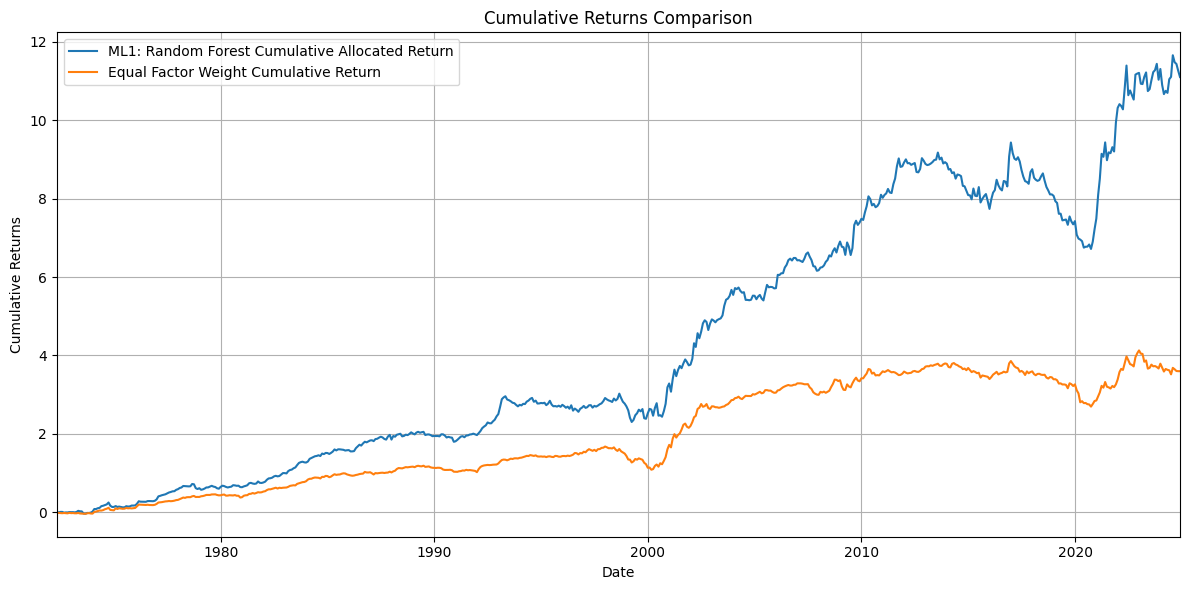

In [ ]:
import matplotlib.pyplot as plt

# Toggle settings
show_50_50_strategy = False  # Toggle for the 50%/50% predicted winner weighted strategy line.
show_benchmark = False       # Toggle for showing benchmark cumulative return(s).
use_log_scale = False         # Toggle for logarithmic (True) or linear (False) y-axis scale.

# Use the cumulative_table built in Cell 2.
df_plot = cumulative_table.copy()

# Determine the plotting date range.
start_date = df_plot['Predicted_month'].min()
end_date   = df_plot['Predicted_month'].max()
print(f"Updated plotting range: {start_date} to {end_date}")
print("Columns available for plotting:", df_plot.columns.tolist())

if start_date == end_date:
    print("⚠ Warning: The dataset might not have updated properly. Try rerunning the previous cell!")

plt.figure(figsize=(12, 6))
plt.clf()  # Clear the figure

# --- Plot each model's cumulative allocated return ---
for col in df_plot.columns:
    if "Cumulative Allocated Return" in col:
        plt.plot(df_plot['Predicted_month'], df_plot[col], label=col)

# --- Plot equal factor weight cumulative return ---
if 'Equal Factor Weight Cumulative Return' in df_plot.columns:
    plt.plot(df_plot['Predicted_month'], df_plot['Equal Factor Weight Cumulative Return'],
             label='Equal Factor Weight Cumulative Return')

# --- Plot benchmark cumulative returns, if toggle is set ---
if show_benchmark:
    if 'Benchmark Cumulative Return' in df_plot.columns:
        plt.plot(df_plot['Predicted_month'], df_plot['Benchmark Cumulative Return'],
                 label='Benchmark Cumulative Return')
    for col in df_plot.columns:
        # Only plot columns with "Mkt" or "Us_standard" that do NOT include "Mkt-RF"
        if (("Mkt" in col or "Us_standard" in col) and
            "Cumulative Return" in col and "Mkt-RF" not in col and col != "Benchmark Cumulative Return"):
            plt.plot(df_plot['Predicted_month'], df_plot[col], label=col)

# --- Plot Predicted Winner Weighted Cumulative Return if available and toggle is on ---
if show_50_50_strategy and 'Predicted Winner Weighted Cumulative Return' in df_plot.columns:
    plt.plot(df_plot['Predicted_month'], df_plot['Predicted Winner Weighted Cumulative Return'],
             label='50%/50% Predicted Winner Strategy')

# --- Format and display the chart ---
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Comparison')
plt.xlim(start_date, end_date)
plt.legend()
plt.grid(True)

# Toggle the y-axis scale
if use_log_scale:
    plt.yscale('log')
else:
    plt.yscale('linear')

plt.tight_layout()
plt.show()


#PERFORMANCE METRICS

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

print("\n=== PERFORMANCE METRICS ===")

def annualized_metrics(monthly_returns):
    """
    Compute the annualized return, volatility, and Sharpe ratio from monthly returns.
    Assumes monthly returns.
    """
    # Fill missing values with 0 to avoid issues.
    monthly_returns = monthly_returns.fillna(0)
    mean_m = monthly_returns.mean()
    std_m = monthly_returns.std()
    ann_ret = mean_m * 12
    ann_vol = std_m * np.sqrt(12)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
    return ann_ret, ann_vol, sharpe

def max_drawdown(monthly_returns):
    """
    Compute the maximum drawdown from a series of monthly returns.
    """
    wealth = (1 + monthly_returns.fillna(0)).cumprod()
    dd_series = wealth / wealth.cummax() - 1
    return dd_series.min()

# ---------------------------------------------------------------------
# Determine the raw return columns from combined_df.
# We assume:
# • "Predicted_month" is the date column.
# • Raw (monthly) return strategy columns either contain "Return"
#   (e.g. "ML1: Random Forest Allocated_Return")
#   OR exactly match BENCHMARK[0] (e.g. "Mkt") or "Benchmark Return"
# We exclude any column that contains "Cumulative" as well as non-return columns.
# ---------------------------------------------------------------------
all_columns = combined_df.columns.tolist()
# Include columns that (a) have "Return" in them (but not "Cumulative"), OR
# are exactly equal to BENCHMARK[0] or "Benchmark Return"
strategy_cols = [
    col for col in all_columns
    if (
         (("Return" in col) or (col == BENCHMARK[0]) or (col == "Benchmark Return"))
         and ("Cumulative" not in col)
         and (col not in ["Actual_Winner", "Predicted_month"])
       )
]

# Display the list of strategy columns for debugging.
print("Strategy columns used for performance metrics:")
print(strategy_cols)

# ---------------------------------------------------------------------
# Loop through each selected strategy column and compute performance metrics.
# ---------------------------------------------------------------------
metrics_list = []
for col in strategy_cols:
    monthly_ret_series = combined_df[col]
    ann_ret, ann_vol, sharpe = annualized_metrics(monthly_ret_series)
    mdd = max_drawdown(monthly_ret_series)

    metrics_list.append({
         "Strategy": col,
         "Annualized Return": f"{ann_ret*100:.2f}%",
         "Annualized Volatility": f"{ann_vol*100:.2f}%",
         "Sharpe Ratio": f"{sharpe:.2f}",
         "Max Drawdown": f"{mdd*100:.2f}%"
    })

# Create a DataFrame with the performance metrics.
metrics_df = pd.DataFrame(metrics_list).sort_values("Strategy").reset_index(drop=True)

# Optionally, sort by another metric (e.g., Sharpe Ratio) if desired.
# metrics_df = metrics_df.sort_values("Sharpe Ratio", ascending=False).reset_index(drop=True)

# Display the performance metrics as an HTML table.
display(HTML(metrics_df.to_html(index=False)))



=== PERFORMANCE METRICS ===
Strategy columns used for performance metrics:
['Mkt', 'Equal_Weight_Return', 'ML1: Random Forest Allocated_Return']


Strategy,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown
Equal_Weight_Return,3.03%,5.08%,0.60,-23.93%
ML1: Random Forest Allocated_Return,5.00%,7.13%,0.70,-26.02%
Mkt,11.74%,15.84%,0.74,-50.39%


##Drawdown chart

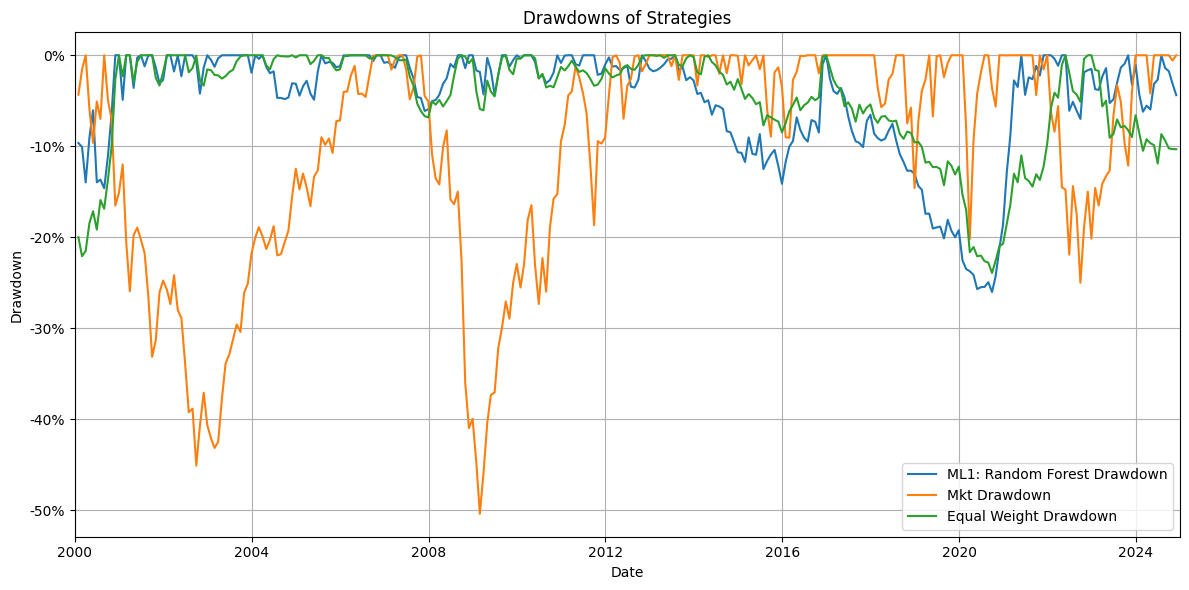

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# -------------------------------------------------------------------------
# 1. TOGGLE OPTIONS
# -------------------------------------------------------------------------
show_benchmark_drawdown = True           # Toggle benchmark drawdown
show_equal_weight_drawdown = True        # Toggle Equal Weight (single) drawdown
show_winner_weighted_drawdown = False     # Toggle Winner Weighted drawdown

# -------------------------------------------------------------------------
# 2. COPY cumulative_table (assumed computed previously)
# -------------------------------------------------------------------------
drawdown_df = cumulative_table.copy()

# -------------------------------------------------------------------------
# 3. CALCULATE DRAWDOWNS USING WEALTH INDEX (Wealth = 1 + Cumulative Return)
# -------------------------------------------------------------------------

# a) For each ML model's cumulative allocated return column:
ml_alloc_cols = [col for col in drawdown_df.columns if "Cumulative Allocated Return" in col]
for col in ml_alloc_cols:
    wealth = 1 + drawdown_df[col]
    drawdown_name = col.replace("Cumulative Allocated Return", "Drawdown")
    drawdown_df[drawdown_name] = wealth / wealth.cummax() - 1

# b) For Benchmark:
# Use the benchmark name from BENCHMARK[0]
benchmark_name = BENCHMARK[0]  # for example, "Mkt"
benchmark_cum_col = f"{benchmark_name} Cumulative Return"
if benchmark_cum_col in drawdown_df.columns:
    wealth = 1 + drawdown_df[benchmark_cum_col]
    drawdown_df[f"{benchmark_name} Drawdown"] = wealth / wealth.cummax() - 1
elif "Mkt Cumulative Return" in drawdown_df.columns:
    wealth = 1 + drawdown_df["Mkt Cumulative Return"]
    drawdown_df["Mkt Drawdown"] = wealth / wealth.cummax() - 1
else:
    print("WARNING: No benchmark cumulative return column found.")

# c) For Equal Weight (single version):
if "Equal Factor Weight Cumulative Return" in drawdown_df.columns:
    wealth = 1 + drawdown_df["Equal Factor Weight Cumulative Return"]
    drawdown_df["Equal Weight Drawdown"] = wealth / wealth.cummax() - 1

# d) For Predicted Winner Weighted:
if "Predicted Winner Weighted Cumulative Return" in drawdown_df.columns:
    wealth = 1 + drawdown_df["Predicted Winner Weighted Cumulative Return"]
    drawdown_df["Winner Weighted Drawdown"] = wealth / wealth.cummax() - 1

# -------------------------------------------------------------------------
# 4. FILTER BY DATE RANGE
# -------------------------------------------------------------------------
start_date = pd.to_datetime("2000-01-01")
end_date   = pd.to_datetime("2024-12-31")
drawdown_df["Predicted_month"] = pd.to_datetime(drawdown_df["Predicted_month"])
plot_df = drawdown_df[(drawdown_df["Predicted_month"] >= start_date) &
                      (drawdown_df["Predicted_month"] <= end_date)]

# -------------------------------------------------------------------------
# 5. PLOT THE DRAWDOWNS
# -------------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.clf()  # Clear any existing figure

# a) Plot each ML model's drawdown (those columns that start with "ML" and contain "Drawdown")
for col in plot_df.columns:
    if col.startswith("ML") and "Drawdown" in col:
        plt.plot(plot_df["Predicted_month"], plot_df[col], label=col)

# b) Plot Benchmark Drawdown if toggled on
if show_benchmark_drawdown:
    # Look for the benchmark drawdown column with the actual benchmark name (e.g., "Mkt Drawdown")
    bench_drawdown_col = f"{benchmark_name} Drawdown"
    if bench_drawdown_col in plot_df.columns:
        plt.plot(plot_df["Predicted_month"], plot_df[bench_drawdown_col], label=bench_drawdown_col)

# c) Plot Equal Weight Drawdown if available
if show_equal_weight_drawdown and "Equal Weight Drawdown" in plot_df.columns:
    plt.plot(plot_df["Predicted_month"], plot_df["Equal Weight Drawdown"], label="Equal Weight Drawdown")

# d) Plot Winner Weighted Drawdown if toggled on
if show_winner_weighted_drawdown and "Winner Weighted Drawdown" in plot_df.columns:
    plt.plot(plot_df["Predicted_month"], plot_df["Winner Weighted Drawdown"], label="Winner Weighted Drawdown")

# Format the y-axis as percentages.
plt.gca().yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda val, _: f"{val*100:.0f}%")
)

# -------------------------------------------------------------------------
# 6. ENSURE THE X-AXIS SPANS EXACTLY THE DEFINED DATE RANGE
# -------------------------------------------------------------------------
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.title("Drawdowns of Strategies")
plt.xlim(start_date, end_date)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##Regression

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from IPython.display import display

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------
subtract_rf    = True
reg_start_date = pd.to_datetime('1950-01-01')
reg_end_date   = pd.to_datetime('2025-01-01')

# -----------------------------------------------------------------------------
# 1. LOAD FAMA–FRENCH DATA
# -----------------------------------------------------------------------------
xls_file = pd.ExcelFile("/content/Gradu/THE_2ND_latest.xlsx")
df_factors = xls_file.parse("FF5", dtype=str)
df_factors["Date"] = pd.to_datetime(df_factors["Date"])

factors      = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
all_ff5_cols = factors + ['RF']

for col in all_ff5_cols:
    df_factors[col] = (
        df_factors[col]
          .str.replace(",", ".", regex=False)
          .astype(float)
          .div(100)    # now in decimal
    )

df_factors = df_factors.sort_values("Date").reset_index(drop=True)

# -----------------------------------------------------------------------------
# 2. PREPARE MODEL NAMES AND STORAGE
# -----------------------------------------------------------------------------
new_model_names        = [f"ML{i}: {k}" for i, k in enumerate(results_dfs.keys(), 1)]
regression_summary_list = []

# -----------------------------------------------------------------------------
# 3. RUN REGRESSIONS FOR EACH MODEL
# -----------------------------------------------------------------------------
for new_model_name in new_model_names:
    col = f"{new_model_name} Allocated_Return"
    if col not in combined_df.columns:
        print(f"Skipping {new_model_name}: no column '{col}'")
        continue

    # filter & rename
    df_model = (
        combined_df.loc[
            (pd.to_datetime(combined_df['Predicted_month']) >= reg_start_date) &
            (pd.to_datetime(combined_df['Predicted_month']) <= reg_end_date),
            ['Predicted_month', col]
        ]
        .rename(columns={col: "Allocated_Return"})
    )
    df_model['Predicted_month'] = pd.to_datetime(df_model['Predicted_month'])

    # merge factors
    merged = (
        pd.merge(df_model,
                 df_factors[['Date'] + all_ff5_cols],
                 left_on="Predicted_month", right_on="Date", how="inner")
          .drop(columns=["Date"])
    )

    # subtract RF?
    if subtract_rf:
        merged['Y'] = merged['Allocated_Return'] - merged['RF']
    else:
        merged['Y'] = merged['Allocated_Return']

    # regress
    X     = sm.add_constant(merged[factors])
    y     = merged['Y']
    model = sm.OLS(y, X, missing='drop').fit()

    # extract
    alpha_dec   = model.params.get('const', np.nan)
    alpha_t     = model.tvalues.get('const', np.nan)
    beta_mkt    = model.params.get('Mkt-RF', np.nan)
    r2          = model.rsquared
    r2_adj      = model.rsquared_adj
    pval        = model.f_pvalue

    # print in percent
    print(f"\n=== {new_model_name} vs. FF5 ===")
    print(model.summary())
    print(f"Monthly Alpha:    {alpha_dec*100:.3f}%")
    print(f"Alpha t‑stat:     {alpha_t:.3f}")
    print(f"Market Beta:      {beta_mkt:.3f}")
    print("="*80)

    # store decimals for table, we'll convert later
    regression_summary_list.append({
        "Model":           new_model_name,
        "Alpha (dec)":     alpha_dec,
        "Alpha t‑stat":    alpha_t,
        "Market Beta":     beta_mkt,
        "R-squared":       r2,
        "Adj. R-squared":  r2_adj,
        "p-value":         pval
    })

# -----------------------------------------------------------------------------
# 4. EQUAL‑WEIGHT STRATEGY
# -----------------------------------------------------------------------------
eq = (
    combined_df.loc[
        (pd.to_datetime(combined_df['Predicted_month']) >= reg_start_date) &
        (pd.to_datetime(combined_df['Predicted_month']) <= reg_end_date),
        ['Predicted_month', 'Equal_Weight_Return']
    ]
    .rename(columns={'Equal_Weight_Return':'EW_Return'})
)
eq['Predicted_month'] = pd.to_datetime(eq['Predicted_month'])

eqm = (
    pd.merge(eq,
             df_factors[['Date'] + all_ff5_cols],
             left_on="Predicted_month", right_on="Date", how="inner")
      .drop(columns=["Date"])
)
if subtract_rf:
    eqm['Y'] = eqm['EW_Return'] - eqm['RF']
else:
    eqm['Y'] = eqm['EW_Return']

X_eq    = sm.add_constant(eqm[factors])
y_eq    = eqm['Y']
model_eq = sm.OLS(y_eq, X_eq, missing='drop').fit()

alpha_eq_dec = model_eq.params.get('const', np.nan)
alpha_eq_t   = model_eq.tvalues.get('const', np.nan)
beta_eq      = model_eq.params.get('Mkt-RF', np.nan)

print("\n=== Equal-Weight vs. FF5 ===")
print(model_eq.summary())
print(f"Monthly Alpha:    {alpha_eq_dec*100:.3f}%")
print(f"Alpha t‑stat:     {alpha_eq_t:.3f}")
print(f"Market Beta:      {beta_eq:.3f}")
print("="*80)

regression_summary_list.append({
    "Model":           "Equal-Weight",
    "Alpha (dec)":     alpha_eq_dec,
    "Alpha t‑stat":    alpha_eq_t,
    "Market Beta":     beta_eq,
    "R-squared":       model_eq.rsquared,
    "Adj. R-squared":  model_eq.rsquared_adj,
    "p-value":         model_eq.f_pvalue
})

# -----------------------------------------------------------------------------
# 5. SUMMARY TABLE (with % conversions)
# -----------------------------------------------------------------------------
df_sum = pd.DataFrame(regression_summary_list)

# convert decimals to percent in new columns
df_sum['Alpha (%)']           = df_sum['Alpha (dec)'] * 100
df_sum['Ann. Alpha (%) comp'] = (1 + df_sum['Alpha (dec)'])**12 - 1
df_sum['Ann. Alpha (%) comp'] = df_sum['Ann. Alpha (%) comp'] * 100
df_sum['Ann. Alpha (%) lin']  = df_sum['Alpha (dec)'] * 12 * 100

# round
df_sum = df_sum.rename(columns={
    'Alpha t‑stat':   'Alpha t‑stat',
    'Market Beta':    'Market Beta',
    'R-squared':      'R²',
    'Adj. R-squared': 'Adj. R²',
    'p-value':        'p‑value'
}).round({
    'Alpha (%)':           3,
    'Alpha t‑stat':        3,
    'Ann. Alpha (%) comp': 3,
    'Ann. Alpha (%) lin':  3,
    'Market Beta':         3,
    'R²':                  3,
    'Adj. R²':             3,
    'p‑value':             3
})

print("\n=== Summary of All Models (in percent) ===")
display(df_sum[[
    'Model',
    'Alpha (%)',
    'Alpha t‑stat',
    'Market Beta',
    'R²',
    'Adj. R²',
    'p‑value',
    'Ann. Alpha (%) comp',
    'Ann. Alpha (%) lin'
]])


=== ML1: Random Forest vs. FF5 ===
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     115.1
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           3.22e-86
Time:                        14:21:40   Log-Likelihood:                 1758.0
No. Observations:                 632   AIC:                            -3504.
Df Residuals:                     626   BIC:                            -3477.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0

,Model,Alpha (%),Alpha t‑stat,Market Beta,R²,Adj. R²,p‑value,Ann. Alpha (%) comp,Ann. Alpha (%) lin
0,ML1: Random Forest,-0.201,-3.206,-0.014,0.479,0.475,0.0,-2.38,-2.406
1,Equal-Weight,-0.364,-31.138,0.005,0.964,0.964,0.0,-4.28,-4.367


In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

print("\n=== PERFORMANCE METRICS ===")

def annual_sharpe(series):
    """
    Calculate the annual Sharpe ratio from a monthly return Series.
    - Annual return = (product(1 + monthly returns)) - 1
    - Annual volatility = std(monthly returns) * sqrt(12)
    - Sharpe = annual return / annual volatility (assuming risk-free rate = 0)
    """
    annual_return = (1 + series).prod() - 1
    annual_vol = series.std() * np.sqrt(12)
    if annual_vol == 0:
        return np.nan
    return annual_return / annual_vol

# ---------------------------------------------------------------------
# 1) Define the date range and filter combined_df accordingly.
# ---------------------------------------------------------------------
start_date = pd.to_datetime("2000-01-01")
end_date   = pd.to_datetime("2024-12-31")

# Filter the merged DataFrame for the desired date range.
df_filtered = combined_df[(combined_df['Predicted_month'] >= start_date) &
                            (combined_df['Predicted_month'] <= end_date)].copy()

# Create a "Year" column from Predicted_month.
df_filtered["Year"] = df_filtered["Predicted_month"].dt.year

# ---------------------------------------------------------------------
# 2) Identify Strategy Columns for Regression Metrics:
#    - ML strategy columns: Expected to have names like "ML1: Random Forest Allocated_Return", etc.
#    - Benchmark: "Benchmark Return"
#    - Equal Weight: "Equal_Weight_Return"
# ---------------------------------------------------------------------
ml_strategy_cols = [col for col in df_filtered.columns
                    if col.startswith("ML") and "Allocated_Return" in col and "Cumulative" not in col]

bench_col = "Benchmark Return" if "Benchmark Return" in df_filtered.columns else None
eq_col    = "Equal_Weight_Return" if "Equal_Weight_Return" in df_filtered.columns else None

print("Strategy columns used for annual Sharpe calculation:")
print("ML Strategy Columns:", ml_strategy_cols)
if bench_col:
    print("Benchmark Column:", bench_col)
if eq_col:
    print("Equal Weight Column:", eq_col)

# ---------------------------------------------------------------------
# 3) Compute Annual Sharpe Ratios for Each Strategy
# ---------------------------------------------------------------------
annual_sharpe_dict = {}

# Compute for each ML model column.
for col in ml_strategy_cols:
    annual_sharpe_dict[col] = df_filtered.groupby("Year")[col].apply(annual_sharpe)

# Compute for benchmark (if available).
if bench_col is not None:
    annual_sharpe_dict[bench_col] = df_filtered.groupby("Year")[bench_col].apply(annual_sharpe)

# Compute for equal weight (if available).
if eq_col is not None:
    annual_sharpe_dict[eq_col] = df_filtered.groupby("Year")[eq_col].apply(annual_sharpe)

# ---------------------------------------------------------------------
# 4) Combine the Results into One DataFrame and Round to 3 Decimals
# ---------------------------------------------------------------------
annual_sharpe_table = pd.DataFrame(annual_sharpe_dict)
annual_sharpe_table = annual_sharpe_table.round(3)

# ---------------------------------------------------------------------
# 5) Display the Annual Sharpe Ratios as a Neatly Formatted HTML Table
# ---------------------------------------------------------------------
display(HTML("<h3>Annual Sharpe Ratios by Year and Strategy</h3>" + annual_sharpe_table.to_html(index=True)))



=== PERFORMANCE METRICS ===
Strategy columns used for annual Sharpe calculation:
ML Strategy Columns: ['ML1: Random Forest Allocated_Return']
Equal Weight Column: Equal_Weight_Return


,ML1: Random Forest Allocated_Return,Equal_Weight_Return
Year,,
2000,1.229,2.423
2001,0.869,1.560
2002,1.984,1.991
2003,1.902,2.047
2004,-0.071,1.364
2005,0.572,0.496
2006,1.939,3.510
2007,-0.889,-2.670
2008,2.937,2.310


ML Strategy Columns: ['ML1: Random Forest Allocated_Return']
Benchmark Column: None
Equal Weight Column: Equal_Weight_Return
Factor Columns: ['SMB', 'HML', 'CMA', 'RMW']


<ipython-input-360-3c36e27a9481>:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_returns[col] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, col))
<ipython-input-360-3c36e27a9481>:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_returns[equal_weight_col] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, equal_weight_col))
<ipython-input-360-3c36e27a9481>:65:

,ML1: Random Forest Allocated_Return,Equal_Weight_Return,SMB,HML,CMA,RMW
Year,,,,,,
2000,0.216,0.273,0.030,0.443,0.381,0.160
2001,0.112,0.178,0.262,0.151,0.110,0.167
2002,0.242,0.156,0.067,0.099,0.196,0.252
2003,0.106,0.044,0.193,0.033,0.120,-0.147
2004,-0.003,0.035,0.072,0.067,-0.062,0.062
2005,0.030,0.012,-0.003,0.089,-0.045,0.010
2006,0.105,0.058,0.017,0.105,0.078,0.030
2007,-0.034,-0.068,-0.079,-0.160,-0.072,0.046
2008,0.102,0.093,0.055,0.021,0.056,0.240


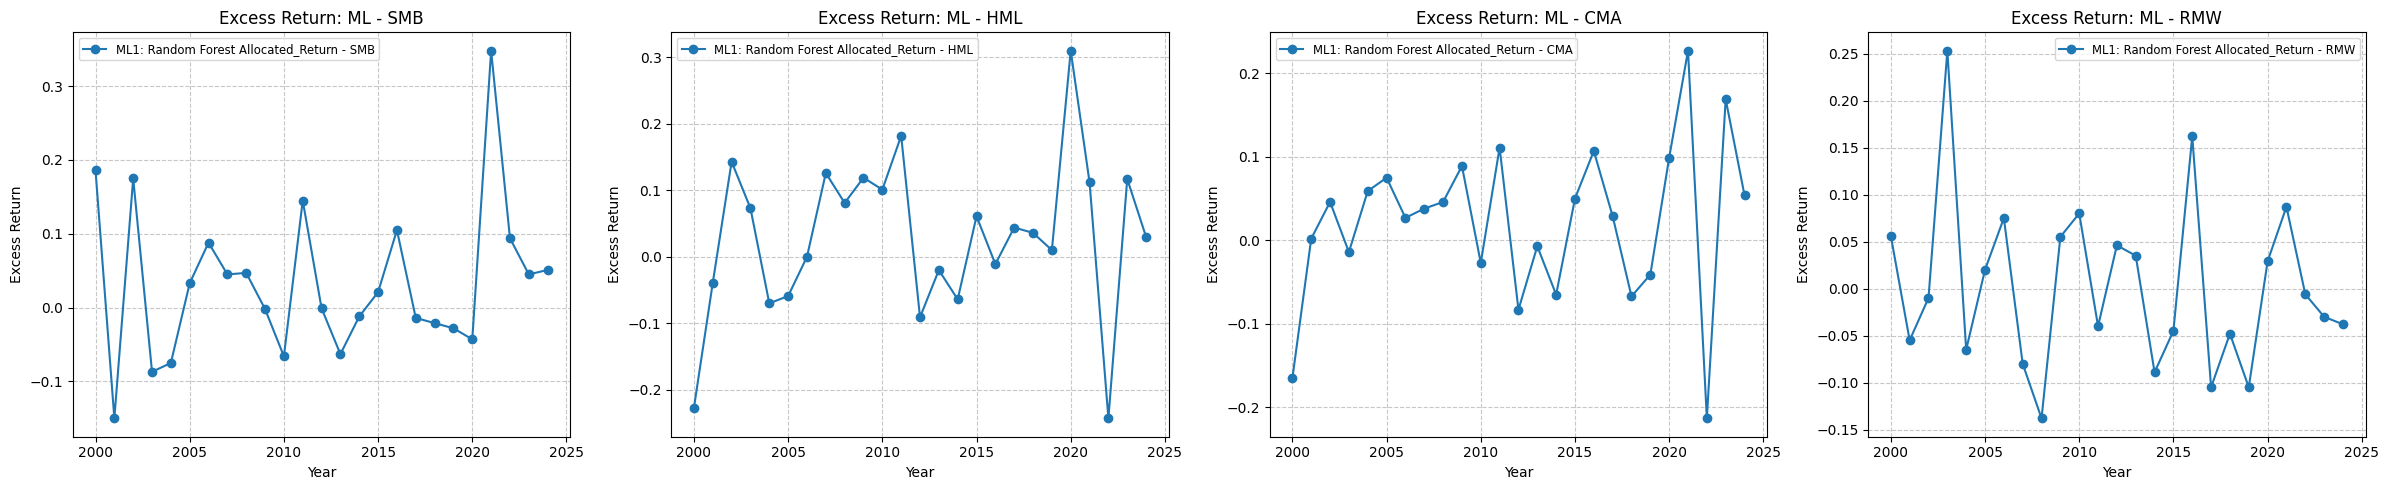


Annual Returns - Equal Weight Strategy:


,Equal_Weight_Return
Year,
2000,0.273
2001,0.178
2002,0.156
2003,0.044
2004,0.035
2005,0.012
2006,0.058
2007,-0.068
2008,0.093


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# ============================================================================
# 1) Prepare Annual Return Data
# ============================================================================

# Define the date range for annual analysis.
start_date = pd.to_datetime("2000-01-01")
end_date   = pd.to_datetime("2024-12-31")

# Filter the merged DataFrame (combined_df) for the desired date range.
# (combined_df comes from your earlier multi‑model merging steps.)
df_annual = combined_df[(combined_df['Predicted_month'] >= start_date) &
                          (combined_df['Predicted_month'] <= end_date)].copy()

# Create a "Year" column.
df_annual['Year'] = df_annual['Predicted_month'].dt.year

# ---------------------------------------------------------------------
# Identify columns:
#   • ML strategy columns: they contain "Allocated_Return" (e.g., "ML1: Random Forest Allocated_Return")
#   • Benchmark: assume the column is "Benchmark Return" (or use what was defined earlier).
#   • Equal Weight: assume "Equal_Weight_Return"
#   • Factor columns: using the global FACTORS (e.g., ['SMB', 'HML', 'CMA', 'RMW'])
# ---------------------------------------------------------------------
ml_cols = [col for col in df_annual.columns if ("Allocated_Return" in col) and ("Cumulative" not in col)]
benchmark_col = "Benchmark Return" if "Benchmark Return" in df_annual.columns else None
equal_weight_col = "Equal_Weight_Return" if "Equal_Weight_Return" in df_annual.columns else None
factor_cols = [fac for fac in FACTORS if fac in df_annual.columns]

print("ML Strategy Columns:", ml_cols)
print("Benchmark Column:", benchmark_col)
print("Equal Weight Column:", equal_weight_col)
print("Factor Columns:", factor_cols)

# ---------------------------------------------------------------------
# Function to compute annual return as the compounded return over the year.
# ---------------------------------------------------------------------
def annual_return(group, col):
    """Compound return over the group: product(1 + r) - 1."""
    return (1 + group[col]).prod() - 1

# ---------------------------------------------------------------------
# Compute annual returns for each strategy.
# We'll build a dictionary where keys are strategy names and values are Series indexed by Year.
annual_returns = {}

# For each ML model column.
for col in ml_cols:
    annual_returns[col] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, col))

# For benchmark.
if benchmark_col is not None:
    annual_returns[benchmark_col] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, benchmark_col))

# For equal weight strategy.
if equal_weight_col is not None:
    annual_returns[equal_weight_col] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, equal_weight_col))

# For each factor.
for fac in factor_cols:
    annual_returns[fac] = df_annual.groupby("Year").apply(lambda grp: annual_return(grp, fac))

# Combine the computed annual returns into one DataFrame.
annual_returns_df = pd.DataFrame(annual_returns)
annual_returns_df = annual_returns_df.round(3)

# Display the Annual Returns Table.
display(HTML("<h3>Annual Returns Table</h3>" + annual_returns_df.to_html()))

# ============================================================================
# 2) Compute Excess Returns and Plot by Factor
# ============================================================================

# For each factor, compute excess return for each ML model relative to that factor.
# We define excess return as: (ML Annual Return) - (Factor Annual Return)
excess_returns = {}
for fac in factor_cols:
    # Create a DataFrame of excess returns for all ML models for factor 'fac'
    excess_df = pd.DataFrame()
    for ml in ml_cols:
        excess_df[ml] = annual_returns_df[ml] - annual_returns_df[fac]
    excess_returns[fac] = excess_df

# Now plot excess returns by factor.
n_factors = len(factor_cols)
if n_factors > 0:
    # Create one subplot per factor.
    fig, axes = plt.subplots(1, n_factors, figsize=(6 * n_factors, 5), sharex=True)
    if n_factors == 1:
        axes = [axes]
    for i, fac in enumerate(factor_cols):
        ax = axes[i]
        # Plot a line for each ML model excess return for this factor.
        for ml in ml_cols:
            ax.plot(excess_returns[fac].index, excess_returns[fac][ml],
                    marker='o', label=f'{ml} - {fac}')
        ax.set_title(f'Excess Return: ML - {fac}')
        ax.set_xlabel("Year")
        ax.set_ylabel("Excess Return")
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(fontsize='small')
    plt.tight_layout()
    plt.show()

# ============================================================================
# 3) (Optional) Compute and Plot Annual Returns for Benchmark and Equal Weight
# ============================================================================

# For convenience, let's display the annual returns for benchmark and equal weight strategies.
if benchmark_col is not None:
    print("\nAnnual Returns - Benchmark:")
    display(annual_returns_df[[benchmark_col]])
if equal_weight_col is not None:
    print("\nAnnual Returns - Equal Weight Strategy:")
    display(annual_returns_df[[equal_weight_col]])


##Return comparison by period

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

# -------------------------------------------------
# 1) Create a "Year" Column in the Merged DataFrame
# -------------------------------------------------
combined_df['Year'] = pd.to_datetime(combined_df['Predicted_month']).dt.year

# -------------------------------------------------
# 2) Define a Function to Calculate Annual Return
# -------------------------------------------------
def annual_return(series):
    """
    Compute the annual compounded return from a monthly return series.
    """
    return (1 + series).prod() - 1

# -------------------------------------------------
# 3) Compute Annual Returns for Each Strategy:
#    a) For each ML model's allocated return.
#    b) For Benchmark Return.
#    c) For Equal Weight Return.
# -------------------------------------------------
# a) For ML models: we assume these columns start with "ML" and contain "Allocated_Return"
ml_cols = [col for col in combined_df.columns
           if col.startswith("ML") and "Allocated_Return" in col and "Cumulative" not in col]
annual_returns_ml = {col: combined_df.groupby("Year")[col].apply(annual_return) for col in ml_cols}

# b) For Benchmark:
annual_return_bench = None
if "Benchmark Return" in combined_df.columns:
    annual_return_bench = combined_df.groupby("Year")["Benchmark Return"].apply(annual_return)

# c) For Equal Weight:
annual_return_eq = None
if "Equal_Weight_Return" in combined_df.columns:
    annual_return_eq = combined_df.groupby("Year")["Equal_Weight_Return"].apply(annual_return)

# -------------------------------------------------
# 4) Compute Annual Returns for Each Factor in FACTORS:
# -------------------------------------------------
annual_returns_factors = {}
for factor in FACTORS:
    if factor in combined_df.columns:
        annual_returns_factors[factor] = combined_df.groupby("Year")[factor].apply(annual_return)

# -------------------------------------------------
# 5) Compute Excess Returns for each ML model relative to each factor.
#    Excess = (ML Model Annual Return) - (Factor Annual Return)
# -------------------------------------------------
excess_returns = {}
for ml_col, ml_series in annual_returns_ml.items():
    df_excess = pd.DataFrame(index=ml_series.index)
    for factor, factor_series in annual_returns_factors.items():
        df_excess[f"Excess ({ml_col} - {factor})"] = ml_series - factor_series
    excess_returns[ml_col] = df_excess

# -------------------------------------------------
# 6) Build a Summary Table of Annual Returns for all Strategies
# -------------------------------------------------
years = sorted(combined_df['Year'].unique())
annual_summary = pd.DataFrame(index=years)

# Add ML model returns.
for ml_col, series in annual_returns_ml.items():
    annual_summary[ml_col] = series

# Add benchmark return if available.
if annual_return_bench is not None:
    annual_summary["Benchmark Return"] = annual_return_bench

# Add equal weight return if available.
if annual_return_eq is not None:
    annual_summary["Equal_Weight_Return"] = annual_return_eq

# -------------------------------------------------
# 7) Display the Summary Table and (optionally) Excess Returns for the First ML Model
# -------------------------------------------------
print("Annual Returns Summary:")
display(annual_summary.round(3))

# Optionally, display excess returns for the first ML model.
first_ml_col = ml_cols[0] if ml_cols else None
if first_ml_col is not None:
    print(f"\nExcess Returns for {first_ml_col}:")
    display(excess_returns[first_ml_col].round(3))


Annual Returns Summary:


,ML1: Random Forest Allocated_Return,Equal_Weight_Return
1972,0.002,-0.022
1973,0.014,-0.012
1974,0.118,0.087
1975,0.034,0.058
1976,0.130,0.093
1977,0.197,0.084
1978,0.016,0.057
1979,0.021,0.031
1980,-0.005,-0.034
1981,0.074,0.104



Excess Returns for ML1: Random Forest Allocated_Return:


,Excess (ML1: Random Forest Allocated_Return - SMB),Excess (ML1: Random Forest Allocated_Return - HML),Excess (ML1: Random Forest Allocated_Return - CMA),Excess (ML1: Random Forest Allocated_Return - RMW)
Year,,,,
1972,0.159,-0.042,0.023,-0.049
1973,0.236,-0.219,-0.082,0.126
1974,0.124,0.008,-0.203,0.181
1975,-0.117,-0.037,0.033,0.032
1976,-0.037,-0.077,0.068,0.182
1977,-0.060,0.124,0.196,0.177
1978,-0.131,0.026,-0.018,-0.036
1979,-0.164,0.036,0.034,0.046
1980,-0.054,0.182,0.091,-0.116


# Corr Heat map & regiimi sharpet


          SMB       HML       CMA       RMW
SMB  1.000000  0.002825 -0.087740 -0.353244
HML  0.002825  1.000000  0.684483  0.083180
CMA -0.087740  0.684483  1.000000 -0.012315
RMW -0.353244  0.083180 -0.012315  1.000000


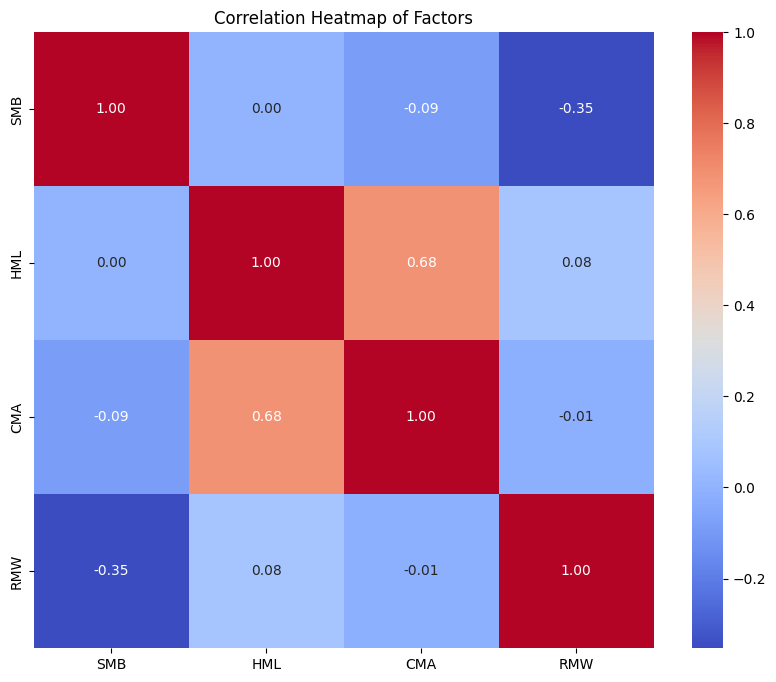

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = xls_file.parse(SHEET_NAME)
df = df[["Date"] + FACTORS]

# Calculate correlations
correlation_matrix = df[FACTORS].corr()

# Show regular correlation table
print(correlation_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Factors")
plt.show()


In [ ]:
import os
import subprocess
import pandas as pd

# --- 1) Clone or pull your repo ---
repo_url  = "https://github.com/Elkkujou/Gradu.git"
repo_name = "Gradu"

if os.path.exists(repo_name):
    subprocess.run(["git", "-C", repo_name, "pull"], check=True)
else:
    subprocess.run(["git", "clone", repo_url], check=True)

# --- 2) Load the Excel sheet into data_ff5 ---
xlsx_path = os.path.join(repo_name, "THE_2ND_latest.xlsx")
xls_file  = pd.ExcelFile(xlsx_path)

SHEET_NAME  = "ajodata_FF5"
data_ff5    = xls_file.parse(SHEET_NAME)

# --- 3) Parse the date column (assumed to be the first column) ---
date_col = data_ff5.columns[0]
data_ff5[date_col] = pd.to_datetime(data_ff5[date_col])

# --- 4) Compute z‑scores for your four features ---
FEATURES = ['CPI%','T10Y3', 'CFNAI', 'GARCH_1M']
z_cols   = [f + '_z' for f in FEATURES]

# Cross‑sample z‑score: (x – mean) / std
data_ff5[z_cols] = data_ff5[FEATURES].apply(lambda x: (x - x.mean()) / x.std())

# --- 5) Quick check ---
print(data_ff5.loc[:, FEATURES + z_cols].head(10))

      CPI%  T10Y3  CFNAI  GARCH_1M    CPI%_z   T10Y3_z  CFNAI_z  GARCH_1M_z
0  0.32776   0.82    NaN  0.409987  0.030707 -0.466658      NaN   -0.727707
1  0.26135   0.70    NaN  0.281066 -0.178386 -0.560180      NaN   -0.962337
2  0.19550   0.69    NaN  0.431188 -0.385715 -0.567974      NaN   -0.689121
3 -0.09756   0.70    NaN  0.444504 -1.308417 -0.560180      NaN   -0.664887
4  0.09766   0.56    NaN  1.526543 -0.693765 -0.669289      NaN    1.304375
5  0.09756   0.62    NaN  0.316026 -0.694080 -0.622528      NaN   -0.898711
6  0.32489   0.63    NaN  0.250391  0.021670 -0.614735      NaN   -1.018163
7  0.19430   0.65    NaN  0.183620 -0.389493 -0.599148      NaN   -1.139685
8 -0.09696   0.69    NaN  0.217851 -1.306528 -0.567974      NaN   -1.077384
9  0.09706   0.75    NaN  0.326239 -0.695654 -0.521213      NaN   -0.880124


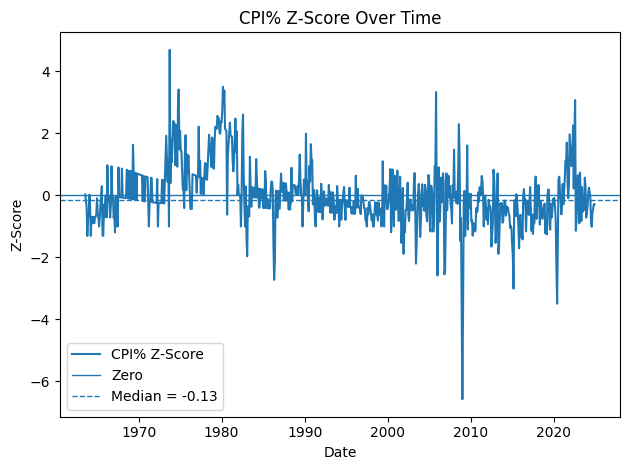

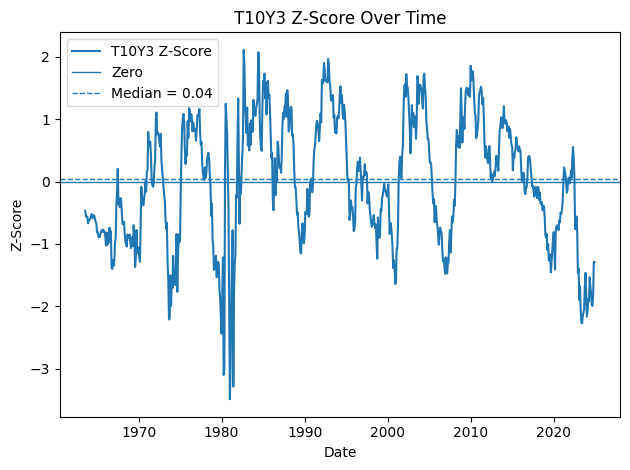

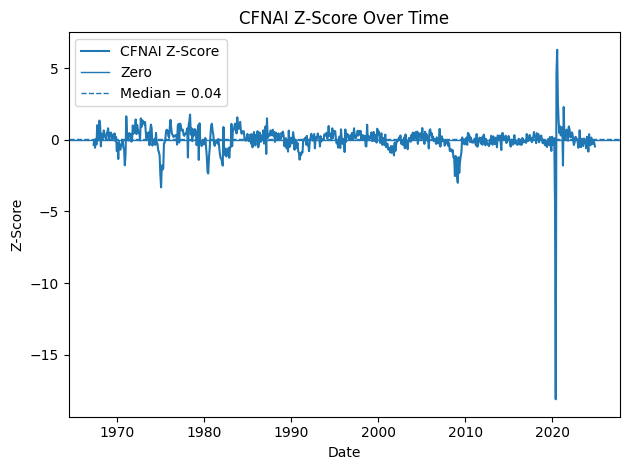

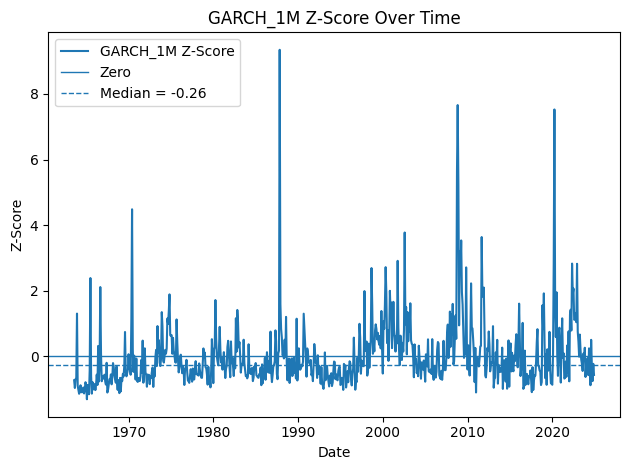

In [ ]:
import matplotlib.pyplot as plt

# 1) Make sure your Date column is datetime and set as index
data_ff5['Date'] = pd.to_datetime(data_ff5.iloc[:, 0])
data_ff5.set_index('Date', inplace=True)

# 2) Define features and their z‑score column names

z_cols   = [f + '_z' for f in FEATURES]

# 3) (Re‑)compute z‑scores if you haven’t yet
data_ff5[z_cols] = data_ff5[FEATURES].apply(lambda x: (x - x.mean()) / x.std())

# 4) Plot each in its own figure
for feat, zc in zip(FEATURES, z_cols):
    median_val = data_ff5[zc].median()

    plt.figure()                          # new figure for each chart
    plt.plot(data_ff5.index, data_ff5[zc], label=f'{feat} Z‑Score')
    plt.axhline(0,        linewidth=1,   label='Zero')
    plt.axhline(median_val, linestyle='--', linewidth=1, label=f'Median = {median_val:.2f}')

    plt.title(f'{feat} Z‑Score Over Time')
    plt.xlabel('Date')
    plt.ylabel('Z‑Score')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd

# 1) Define your features and factors

ZCOLS    = [f + '_z' for f in FEATURES]
FACTORS  = ['SMB', 'HML', 'CMA', 'RMW']

# 2) Prepare an empty DataFrame to hold Sharpe ratios
cols = []
for feat in FEATURES:
    cols += [f"{feat} > 0 SR", f"{feat} < 0 SR"]
sharpe_df = pd.DataFrame(index=FACTORS, columns=cols, dtype=float)

# 3) Compute annualized Sharpe = √12 * mean(return) / std(return)
for feat, zcol in zip(FEATURES, ZCOLS):
    for fac in FACTORS:
        mask_pos = data_ff5[zcol] > 0
        mask_neg = ~mask_pos

        r_pos = data_ff5.loc[mask_pos, fac]
        r_neg = data_ff5.loc[mask_neg, fac]

        # avoid division by zero
        sr_pos = np.sqrt(12) * r_pos.mean() / r_pos.std() if r_pos.std() != 0 else np.nan
        sr_neg = np.sqrt(12) * r_neg.mean() / r_neg.std() if r_neg.std() != 0 else np.nan

        sharpe_df.loc[fac, f"{feat} > 0 SR"] = sr_pos
        sharpe_df.loc[fac, f"{feat} < 0 SR"] = sr_neg

# 4) Round and display
sharpe_df = sharpe_df.round(3)
print(sharpe_df)

     CPI% > 0 SR  CPI% < 0 SR  T10Y3 > 0 SR  T10Y3 < 0 SR  CFNAI > 0 SR  \
SMB        0.007        0.396         0.454         0.050         0.115   
HML        0.583        0.128         0.552         0.117         0.468   
CMA        0.698        0.225         0.617         0.284         0.537   
RMW        0.717        0.271         0.759         0.189         0.456   

     CFNAI < 0 SR  GARCH_1M > 0 SR  GARCH_1M < 0 SR  
SMB         0.351           -0.257            0.638  
HML         0.177            0.217            0.435  
CMA         0.330            0.812            0.152  
RMW         0.427            0.628            0.297  


In [ ]:
# # Plot Regime-wise Correlation Heatmaps
#
# For the selected return columns, compute and plot the correlation matrix
# for each market regime as a heatmap.

# %%
# Use the global FACTORS instead of redefining returns_columns
unique_regimes = df[REGIMES_COLUMN].unique()
for regime in unique_regimes:
    regime_data = df[df[REGIMES_COLUMN] == regime][FACTORS]
    corr = regime_data.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title(f"Return Correlation Heatmap - {regime}")
    plt.tight_layout()
    plt.show()



KeyError: 'Predicted_reg'

In [ ]:
# # Plot Sharpe Ratios by Market Regime
#
# Compute and visualize Sharpe ratios for selected factors across each regime,
# as well as the unconditional (all-data) values, using a bar chart.
# The numeric regime codes are converted back to their original names using the regime_mapping,
# and then further shortened using regime_short_mapping.

# %%
# Define factors and regime columns (using global variables if already defined)
factors_columns = FACTORS
regimes_column = REGIMES_COLUMN   # Assumes REGIMES_COLUMN was defined earlier

# Use the previously created regime_short_mapping to convert numeric codes back to short names.
# (If a code is not in regime_short_mapping, it will default to "Regime <code>")
regime_short_names = {reg: regime_short_mapping.get(reg, f"Regime {reg}")
                      for reg in df[regimes_column].unique()}

sharpe_ratios = {
    regime_short_names[regime]: (
        df[df[regimes_column] == regime][factors_columns].mean() /
        df[df[regimes_column] == regime][factors_columns].std()
    )
    for regime in df[regimes_column].unique()
}

# Calculate the "Unconditional" Sharpe ratios (using all data)
sharpe_ratios["Unconditional"] = df[factors_columns].mean() / df[factors_columns].std()

# Convert the dictionary to a DataFrame and set column names
sharpe_ratios_df = pd.DataFrame(sharpe_ratios).T
sharpe_ratios_df.columns = factors_columns

# Plot the Sharpe ratios using the same styling as before.
plt.figure(figsize=(14, 8))
sharpe_ratios_df.plot(
    kind="bar",
    grid=True,
    colormap="viridis",
    title="Sharpe Ratios by Regime and Unconditional",
    figsize=(14, 8)
)
plt.ylabel("Sharpe Ratio", fontsize=12)
plt.xlabel("Market Regimes", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title="Factors", fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


##Feature importance by period

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ======= USER-DEFINED DATE RANGE =======
# Adjust these dates to view feature importances for a specific period
start_date = pd.to_datetime('2020-01-01')
end_date   = pd.to_datetime('2022-12-31')

# ======= Filter the Data =======
# Filter the results_df for the specified date range based on the 'Predicted_month' column
filtered_results_df = results_df[
    (results_df['Predicted_month'] >= start_date) &
    (results_df['Predicted_month'] <= end_date)
]

# ======= Get Unique Regimes and Feature Count =======
existing_regimes = filtered_results_df['Regime'].unique()
n_regimes = len(existing_regimes)
n_features = len(filtered_results_df['Feature_Importances'].iloc[0])  # Assumes each entry is a vector

# ======= Robust Feature Naming =======
try:
    # Validate if the predefined FEATURES list matches the actual feature count
    if len(FEATURES) != n_features:
        print(f"⚠️ Warning: FEATURES list length ({len(FEATURES)}) doesn't match model features ({n_features}).")
        print("Using auto-generated feature names instead.")
        raise ValueError
    feature_names = FEATURES
except (NameError, ValueError):
    # Generate default feature names if there's a mismatch or if FEATURES is undefined
    feature_names = [f'Feature {i+1}' for i in range(n_features)]
    print(f"Using auto-generated feature names for {n_features} features.")

# ======= Compute Overall Average Feature Importances =======
overall_avg_fi = np.vstack(filtered_results_df['Feature_Importances'].values).mean(axis=0)

# ======= Compute Regime-Specific Average Feature Importances =======
regime_avg_fi = {}
for regime_name in existing_regimes:
    regime_df = filtered_results_df[filtered_results_df['Regime'] == regime_name]
    regime_fi_array = np.vstack(regime_df['Feature_Importances'].values)
    regime_avg_fi[regime_name] = regime_fi_array.mean(axis=0)

# ======= Sort Features by Overall Importance (Descending) =======
sorted_idx = overall_avg_fi.argsort()[::-1]
sorted_idx = sorted_idx[sorted_idx < len(feature_names)]  # Ensure index bounds
sorted_features = [feature_names[i] for i in sorted_idx]

# ======= Plotting =======
if n_regimes > 1:
    total_plots = 1 + n_regimes  # One overall plot plus one for each regime
    row_height = max(0.3 * n_features, 4)
    fig, axs = plt.subplots(
        total_plots,
        1,
        figsize=(19.5, total_plots * row_height),
        gridspec_kw={'hspace': 0.4}
    )
    if total_plots == 1:
        axs = [axs]

    # --- Overall Feature Importances ---
    axs[0].barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    axs[0].set_yticks(np.arange(n_features))
    axs[0].set_yticklabels(sorted_features)
    axs[0].set_title("Overall Average Feature Importances", pad=12)
    axs[0].set_xlabel("Average Importance")
    axs[0].grid(axis='x', linestyle='--', alpha=0.7)

    # --- Regime-Specific Feature Importances ---
    for idx, (regime_name, avg_fi) in enumerate(regime_avg_fi.items(), start=1):
        sorted_regime_fi = avg_fi[sorted_idx]
        axs[idx].barh(
            np.arange(n_features),
            sorted_regime_fi,
            color='salmon',
            edgecolor='black'
        )
        axs[idx].set_yticks(np.arange(n_features))
        axs[idx].set_yticklabels(sorted_features)
        axs[idx].set_title(f"Feature Importances: {regime_name} Regime", pad=12)
        axs[idx].set_xlabel("Average Importance")
        axs[idx].grid(axis='x', linestyle='--', alpha=0.7)
else:
    # If zero or one regime, show only the overall chart
    row_height = max(0.3 * n_features, 4)
    fig, ax = plt.subplots(
        1, 1, figsize=(19.5, row_height),
        gridspec_kw={'hspace': 0.4}
    )
    ax.barh(
        np.arange(n_features),
        overall_avg_fi[sorted_idx],
        color='steelblue',
        edgecolor='black'
    )
    ax.set_yticks(np.arange(n_features))
    ax.set_yticklabels(sorted_features)
    ax.set_title("Overall Average Feature Importances (No Multiple Regimes)", pad=12)
    ax.set_xlabel("Average Importance")
    ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout(pad=4.0)
plt.subplots_adjust(left=0.3)  # Extra space for feature labels
plt.show()